# EMNLP

In [2]:
# built-in libraries

import itertools
import time
import util
import json
import re
import os
import pickle
import time

# Libraries that need to be installed

import pandas as pd
import numpy as np

from joblib import Parallel, delayed, Memory
from joblib import wrap_non_picklable_objects
memory = Memory("cache", verbose=0)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import fuzzy
import flair
from flair.data import Sentence
from flair.models import SequenceTagger
from dateutil.parser import parse
from nameparser import HumanName
import scipy.stats
import sklearn

# External file
import abbrev

# needed by Flair because of multiple OMP lib links in my install
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Display the library versions used.

In [3]:
flair.device

device(type='cuda', index=0)

In [4]:
np.__version__

'1.20.2'

In [5]:
np.__config__.show()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


`DIR` contains the path of the data download.

`dl_date` is the date the data was downloaded

`years` contains the decades of interest. It will be used in loops througout the code.

In [23]:
DIR="data"
dl_date="20200604"
years = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

# Load Data

## Set up 50 states info

In [8]:
# convert from jurisdiction code to two-letter abbreviations
states_code={'ala':"AL",
        'alaska':"AK",
        'am-samoa':"AS",
             'ariz':"AZ",
             'cal':'CA',
             'colo':'CO',
             'conn':'CT',
             'dakota-territory':'XDT',
             'dc':'DC',
             'del':'DE',
        'fla':'FL','ga':'GA','guam':'GU','haw':'HI','idaho':'ID','ind':'IN','iowa':'IA','kan':'KS','ky':'KY','la':'LA',
             'mass':'MA','md':'MD','me':'ME',
        'mich':'MI','minn':'MN','miss':'MS','mo':'MO','mont':'MT','n-mar-i':'MP','navajo-nation':'XNN','nd':'ND',
             'neb':'NE','nev':'NV','nh':'NH',
        'nj':'NJ','ny':'NY','ohio':'OH','okla':'OK','or':'OR','pa':'PA','pr':'PR','ri':'RI','sc':'SC','sd':'SD','tenn':'TN',
             'tex':'TX','tribal':'XTB','uk':'XUK',
        'us':'XUS','utah':'UT','va':'VA','vi':'VI','vt':'VT','w-va':'WV','wash':'WA','wis':'WI','wyo':'WY',
        'ark':'AR','ill':'IL','nc':'NC','nm':'NM'}

In [9]:
# set up a dictionary for convert from two-letter abbreviations to jurisdiction codes
states_convert = {v:k for k,v in states_code.items()}

In [10]:
# pretty names for each code
states_name = {
        'XDT':'Dakota Territory',
        'XNN':'Navajo Nation',
        'XTB':'Tribal Territory',
        'XUS':'US Federal',
        'XUK':'UK',
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [11]:
# Pretty names for jurisdiction codes
states_desc = {}
for state, a in states_code.items():
    states_desc[state] = states_name[a]
states_desc    

{'ala': 'Alabama',
 'alaska': 'Alaska',
 'am-samoa': 'American Samoa',
 'ariz': 'Arizona',
 'cal': 'California',
 'colo': 'Colorado',
 'conn': 'Connecticut',
 'dakota-territory': 'Dakota Territory',
 'dc': 'District of Columbia',
 'del': 'Delaware',
 'fla': 'Florida',
 'ga': 'Georgia',
 'guam': 'Guam',
 'haw': 'Hawaii',
 'idaho': 'Idaho',
 'ind': 'Indiana',
 'iowa': 'Iowa',
 'kan': 'Kansas',
 'ky': 'Kentucky',
 'la': 'Louisiana',
 'mass': 'Massachusetts',
 'md': 'Maryland',
 'me': 'Maine',
 'mich': 'Michigan',
 'minn': 'Minnesota',
 'miss': 'Mississippi',
 'mo': 'Missouri',
 'mont': 'Montana',
 'n-mar-i': 'Northern Mariana Islands',
 'navajo-nation': 'Navajo Nation',
 'nd': 'North Dakota',
 'neb': 'Nebraska',
 'nev': 'Nevada',
 'nh': 'New Hampshire',
 'nj': 'New Jersey',
 'ny': 'New York',
 'ohio': 'Ohio',
 'okla': 'Oklahoma',
 'or': 'Oregon',
 'pa': 'Pennsylvania',
 'pr': 'Puerto Rico',
 'ri': 'Rhode Island',
 'sc': 'South Carolina',
 'sd': 'South Dakota',
 'tenn': 'Tennessee',
 'tex'

In [12]:
# The states of interest; HI and AK are not included
states = ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 
               'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 
               'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 
               'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
len(states)

49

In [13]:
# the list above, but using jurisdiction codes
states_code_keep = [state for state,code in states_code.items() if code in states]
states_code_keep[:10]

['ala', 'ariz', 'cal', 'colo', 'conn', 'dc', 'del', 'fla', 'ga', 'idaho']

In [15]:
cities_csv = pd.read_csv("pop/uscities.csv")[["city", "state_id"]]
cities = set(cities_csv.city + ", " + cities_csv.state_id)
cities = cities | set(cities_csv.city)

# Utilities

In [65]:
def getDecade(dt):
    'Extract the decade from a date in ISO format.'
    y = dt.split("-")
    return round(int(y[0]), -1)

def getDataFile(state):
    'For a given state code, return the data file to load.'
    if state not in states_code:
        if state in states_convert:
            state = states_convert[state]
        else:
            raise "Invalid state %s"%state
    return f"{DIR}/{state}_text_{dl_date}/data/data.jsonl"

In [17]:
def countCases(state):
    'Count the number of cases in a state.'
    # first count number of cases
    with open(getDataFile(state), "r") as f:
        total = 0
        for s in f:
            total += 1
    return total

def loopCases(state, since1900=True):
    'Return a generator listing every cases in state.'
    with open(getDataFile(state), "r") as f:
        for s in f:
            j = json.loads(s)
            if since1900:
                dt = j['decision_date']
                if getDecade(dt)<1900: continue 
            yield j
                
def loopCasesAttorneysText(state, since1900=True):
    'Return a generator listing all attorneys in all cases in state.'
    for j in loopCases(state, since1900):
        alist = j['casebody']['data']['attorneys']
        for a in alist:
            yield a

Utilites for loading lawyers into network graphs for later analysis.

In [18]:
def loopAttorneys(j, fast=True, year=None, state=None, standardize=True, debug=False):
    '''Extract lawyer names from case json (generator).'''
    dt = getDecade(j["decision_date"])
    if year:
        if dt != year: return
    else:
        if dt < 1900: return
    a = j['casebody']['data']['attorneys']
    if fast:
        l = extractNamesSimple(a, debug=debug)
    else:
        l = extractNamesState(a, debug=debug)
    for n in l:
        if standardize:
            n = sanitizeLookup(n, state, year)
        yield {"id":j['id'], "name":n, "year":dt}

# def loadAttorneys(j, year=None, state=None):
#     for a in loopAttorneys(j, year, state=state):
#         n = a["name"]
#         if n in attorneys:
#             attorneys[n] += 1
#         else:
#             attorneys[n] = 1

# def subdict(k, v, indent):
#     if isinstance(v, dict):
#         print(" "*indent, k)
#         for kk, vv in v.items():
#             subdict(kk, vv, indent+2)
#     elif isinstance(v, list):
#         if len(v) > 0:
#             if isinstance(v[0], dict):
#                 print( " "*indent, k, "[dict]")
#                 for kk, vv in v[0].items():
#                     subdict(kk, vv, indent+2)
#             else:
#                 print( " "*indent, k, "list of", type(v[0]))
#         else:
#             print( " "*indent, k, type(v))
#     else:
#         print( " "*indent, k, type(v))

def loadWeights(fn, year, weighted=True):
    glist = {}
    with open(fn, "r") as f:
        for s in f:
            j = json.loads(s)
            for a in loopAttorneys(j, year):
                if a["year"] != year: continue
                i = a["id"]
                n = a["name"]
                if i in glist:
                    glist[i].append(n)
                else:
                    glist[i] = [n]

    weights = {}
    count = 0
    for id, a in glist.items():
        count += 1
        # if count > 500: break
        u = np.unique(a)
        for c in itertools.combinations(u, 2):
            if weighted:
                if c in weights:
                    weights[c] += 1
                else:
                    weights[c] = 1
            elif c not in weights:
                weights[c] = 1

    return weights

def average_degree(G):
    return sum(dict(G.degree()).values()) / float(len(G))

def median_degree(G):
    return np.median(dict(G.degree()))

def average_dict(G):
    return sum(G.values()) / float(len(G))

def countCases(state):
    fn = getDataFile(state)
    c = 0
    with open(fn, "r") as f:
        for s in f:
            c += 1
    return c

def loadYearlyNamesCount(state, standardize=True, fast=True, count=None, debug=False):
    fn = getDataFile(state)
    g = {}
    c = 0
    with open(fn, "r") as f:
        for s in f:
            j = json.loads(s)
            for a in loopAttorneys(j, fast=fast, standardize=standardize, debug=debug):
                c += 1
                if count and c>count: return g
                name = a["name"]
                year = a["year"]
                if len(name)<2: continue
                if year in g:
                    if name in g[year]:
                        g[year][name] += 1
                    else:
                        g[year][name] = 1
                else:
#                     print("year", type(year), ":",name,"!")
                    g[year] = {name:1}
    return g

def loadYearlyNames(state, standardize=True, fast=True, count=None, debug=False):
    fn = getDataFile(state)
    g = {}
    c = 0
    with open(fn, "r") as f:
        for s in f:
            j = json.loads(s)
            for a in loopAttorneys(j, fast=fast, standardize=standardize, debug=debug):
                c += 1
                if count and c>count: return g
                name = a["name"]
                year = a["year"]
                if len(name)<2: continue
                if year in g:
                    g[year].add(name)
                else:
#                     print("year", type(year), ":",name,"!")
                    g[year] = {name}
    return g

@memory.cache
def loadYearlyGraph(state, year, weighted=True, save=True):
#     filename = f"out/{state}-graph-{year}.pkl"   
#     if state and os.path.exists(filename):
#         return pickle.load(open(filename, "rb"))

    fn = getDataFile(state)
    weights = loadWeights(fn, year, weighted)
    g = nx.Graph()
    for a, v in weights.items():
        g.add_edge(a[0], a[1], weight=v)

#     if save:
#         pickle.dump(g, open(filename, "wb"))
        
    return g

In [19]:
def plotDistribution(v, e=None, file=None, label="Data", title=None, xlabel=None, 
                     bins=25, figsize=(6,4), center=True, noise=None):
    '''Plot a histogram of a distribution and add optional distribution fit.'''
                     
    plt.figure(figsize=figsize)
                     
    if noise is not None:
        if isinstance(noise, bool):
            noise = (max(v) - min(v)) / bins / 2
        v += random.uniform(-noise, noise)
        
    db, xbins, _ = plt.hist(v, bins=bins, label=label)

    if e:
        xbins = xbins[1:]
        if center:
            xbins -= (xbins[1]-xbins[0])/2
        vfit, vtest = sklearn.model_selection.train_test_split(v, train_size=0.5)
        for dist in listify(e):
            d = eval(f"scipy.stats.{dist}")
            s = d.fit(vfit)
            r = scipy.stats.kstest(vtest, dist, args=s)
            print("mean,var,skew,kurtosis", d.stats(*s), "parm", s)
            print("mean", d.mean(*s))
            print("fit", r)

            plt.ylim(0, np.max(db)*1.1)

            best_fit_line = d.pdf(xbins, *s)
            scale = np.max(db) / np.max(best_fit_line)
            plt.plot(xbins, best_fit_line * scale, label=f"{dist.capitalize()}")
    
    plt.ylabel("Frequency")
    if xlabel:
        plt.xlabel(xlabel)
    if title:
        plt.title(title)
    else:
        plt.title(f"Distribution {e}")
    plt.legend()
    if file:
        plt.savefig(file)
    plt.show()

In [20]:
def runParallel(func, data, pool=True, flatten=False, jobs=15):
    'Execute a function in parallel using pools.'
    from collections.abc import Iterable
    if isinstance(data, Iterable):
        data = list(data)
    if pool or jobs>1:
        if not isinstance(data[0], (list, tuple)):
            data = [[item] for item in data]
        results = Parallel(n_jobs=jobs)(delayed(func)(*item) for item in data)
    else:
        results = map(func, data)
    if flatten:
        return [item for sublist in results for item in sublist]
    else:
        return results

In [21]:
def parloop(funcx=None, jobs=4, flatten=False):
    '''Decorator to parallelize a loop over a function. Usage:
    
    @parloop(jobs=2)
    def square(a):
        return a*a
    x = square([4,5,6])
    
    # x is [16,25,36]
    '''
    def inner(func):
        def loop_list(items):
            if jobs <= 1:
                results = []
                for i in items:
                    x = func(i)
                    results.append(x)
            else:
                joblist = []
                for i in items:
                    if isinstance(i, str):
                        joblist.append(delayed(func)(i))
                    elif hasattr(i, "__len__"):
                        joblist.append(delayed(func)(*i))
                    else:
                        joblist.append(delayed(func)(i))
                results = Parallel(n_jobs=jobs)(joblist)

            if flatten:
                return [item for sublist in results for item in sublist]
            else:
                return results

            return results

        return loop_list

    # is decorator called without parameters or parethesis?
    if callable(funcx):
        # do a little hack to make it work
        return inner(funcx)

    return inner

In [22]:
def listify(e):
    if isinstance(e, (list, tuple)): return list(e)
    else: return [e]
listify("abc"), listify(["abc","def"]), listify(("abc","def"))

(['abc'], ['abc', 'def'], ['abc', 'def'])

### Test parallel code to illustrate how it works

In [24]:
def testPar(a):
    print(a)
    return a,2,3
runParallel(testPar, ["ab","cd","ef"], flatten=True, jobs=2)

['ab', 2, 3, 'cd', 2, 3, 'ef', 2, 3]

In [25]:
list(itertools.product(["ab","cd","ef"],["xyz"],[2000]))

[('ab', 'xyz', 2000), ('cd', 'xyz', 2000), ('ef', 'xyz', 2000)]

In [26]:
def testPar(a,b,c):
    print(a,b,c)
    return 9        
runParallel(testPar, list(itertools.product(["ab","bc","cd"],["x"],[2000])), jobs=2)

[9, 9, 9]

In [27]:
@parloop
def square(a):
    return a*a

square([2,4,6])

[4, 16, 36]

# Load the NER & PoS models

In [28]:
tagger = SequenceTagger.load('ner-fast')

2021-09-24 14:01:57,472 --------------------------------------------------------------------------------
2021-09-24 14:01:57,473 The model key 'ner-fast' now maps to 'https://huggingface.co/flair/ner-english-fast' on the HuggingFace ModelHub
2021-09-24 14:01:57,473  - The most current version of the model is automatically downloaded from there.
2021-09-24 14:01:57,474  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-fast/en-ner-fast-conll03-v0.4.pt)
2021-09-24 14:01:57,474 --------------------------------------------------------------------------------
2021-09-24 14:01:57,629 loading file /home/ftrias/.flair/models/ner-english-fast/4c58e7191ff952c030b82db25b3694b58800b0e722ff15427f527e1631ed6142.e13c7c4664ffe2bbfa8f1f5375bd0dced866b8c1dd7ff89a6d705518abf0a611


In [29]:
tagger_pos = SequenceTagger.load('pos')

2021-09-24 14:02:03,320 --------------------------------------------------------------------------------
2021-09-24 14:02:03,321 The model key 'pos' now maps to 'https://huggingface.co/flair/pos-english' on the HuggingFace ModelHub
2021-09-24 14:02:03,321  - The most current version of the model is automatically downloaded from there.
2021-09-24 14:02:03,322  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/pos/en-pos-ontonotes-v0.5.pt)
2021-09-24 14:02:03,322 --------------------------------------------------------------------------------
2021-09-24 14:02:03,449 loading file /home/ftrias/.flair/models/pos-english/a9a73f6cd878edce8a0fa518db76f441f1cc49c2525b2b4557af278ec2f0659e.121306ea62993d04cd1978398b68396931a39eb47754c8a06a87f325ea70ac63


In [30]:
tagger_hcl = SequenceTagger.load('resources/taggers/caselaw-ner/final-model.pt')

2021-09-24 14:02:37,624 loading file resources/taggers/caselaw-ner/final-model.pt


Count the number of parameters for each of the pre-trained models.

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [32]:
count_parameters(tagger)

19397142

In [33]:
count_parameters(tagger_pos)

62243302

In [34]:
count_parameters(tagger_hcl)

63253168

# Naming

This section contains various functions to help parse and validate names.

In [36]:
from nicknames import NameDenormalizer
nickname = NameDenormalizer()
def getFormalName(x):
    'For a given nickname x, find the best formal name (the longest one).'
    names = nickname.get(x)
    names.add(x)
    longest = max(names, key=len)
    return longest.capitalize()
    
def sanitizeName(x):
    'For a name, parse it and substitute nicknames.'
    hn = HumanName(x)
    sub = nickname.get(hn.first)
#     print(sub)
    hn.first = getFormalName(hn.first)
    return hn.full_name

sanitizeName("James, Bill Bell")

'William Bell James'

In [38]:
# this is a cache of pre-processed names segmented by state and decade that need to be manually updated. 
# It is a dictionary where the key is the state code and the value is another dictionary. For that 
# dictionary, the key is the (year, name) and the value is the formal name.
if os.path.exists("out/names_lookup.pkl"):
    names_lookup = pickle.load(open("out/names_lookup.pkl", "rb"))
else:
    names_lookup = {}
    
def sanitizeLookup(x, state, year):
    'For a given (name, state, year), parse it, formalize it and return the formal version.'
    if state not in names_lookup:
        try:
            hn = HumanName(x).full_name
        except Exception as ex:
            print("Bad name", x, ex)
            return x
        return hn
    p = names_lookup[state]
    if (year, x) in p:
        x = p[year, x]
    try:
        hn = HumanName(x).full_name
    except Exception as ex:
            print("Bad name", x, ex)
            return x
    return hn
sanitizeLookup("william cunninghame", "ala", 1900)

'william cunninghame'

In [39]:
import abbrev
abbrev_name_pattern = re.compile(r"^([A-Z][a-z]+)\.")
def cleanAbbreviation(n):
    'For a given full name, find the abbreviations and substitute the unabbreviated name.'
    m = abbrev_name_pattern.match(n)
    if m:
        new = abbrev.get(m.group(1))
#         print("group", m.group(1), new)
        return new + n[m.end():]
    return n

cleanAbbreviation("Geo. W. James")

'George W. James'

## Simple text-matching system

This model was not used in the paper and is provided here as a reference. It finds names by simple pattern matching (regular expressions, text, etc).

In [40]:
import re, string; 
valid_name_characters = r"[^ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz &]"
valid_name_pattern = re.compile(valid_name_characters)
space_name_pattern = re.compile(r" +")

def cleanName(n):
    n = n.replace('0.', 'O.') # typical OCR
    n = valid_name_pattern.sub('', n)
    n = space_name_pattern.sub(' ', n)
    return n.strip()

cleanName("Jack M. . O'hara")

'Jack M Ohara'

In [41]:
# state_sub = ""
# for name in states_name.values():
#     state_sub += name+"|"
# state_sub
skip_phrases = r'(\A|[,\. ;])(for appellant|for appellee|for petitioner|opposed|judge|atty|gen|Attorney|General|Asst|Attys|defendant|deputy|student|' \
    r'intern|reprenenting|appellee|senior|argument|appellate|state|former|criminal|appeals?|chief|attornerygeneral|real party in interest|esquire|pro se|' \
    r'l\.?l\.?c\.?|p\.?c\.?|inc\.|' \
    r'united states|attorneys|record no|et al|division|commission|dept\.?|highway|system|defense|both|behalf|' \
    r'assistant|defender|public|city|attorney|counsel|law|office|department|firm|secretary|sec\.|' \
    r'all|the|both|amici|amicus|curiae|county|appellant|appellee|petitioner|argued|cause|' \
    r'opposed|atty|gen|general|asst|attys|public|personnel|agency|district)(\Z|[,\. ;])'
skip_phrases_pattern = re.compile(skip_phrases, re.IGNORECASE)
def cleanPhrases(n, debug=False):
    for i in range(100):
        m = skip_phrases_pattern.search(n)
        if m:
            n = n[:m.start(2)]+" "+n[m.end(2):]
            if debug: print(m, n)
        else:
            break
    return n
cleanPhrases("A. A. Griffith and Earney Bland, both of Cullman, for petitioner; E. E. St. John, of Cullman, State Atty. Gen., opposed. James R. Joyce.", True)

<re.Match object; span=(32, 38), match=' both '> A. A. Griffith and Earney Bland,   of Cullman, for petitioner; E. E. St. John, of Cullman, State Atty. Gen., opposed. James R. Joyce.
<re.Match object; span=(46, 62), match=' for petitioner;'> A. A. Griffith and Earney Bland,   of Cullman,  ; E. E. St. John, of Cullman, State Atty. Gen., opposed. James R. Joyce.
<re.Match object; span=(77, 84), match=' State '> A. A. Griffith and Earney Bland,   of Cullman,  ; E. E. St. John, of Cullman,   Atty. Gen., opposed. James R. Joyce.
<re.Match object; span=(79, 85), match=' Atty.'> A. A. Griffith and Earney Bland,   of Cullman,  ; E. E. St. John, of Cullman,    . Gen., opposed. James R. Joyce.
<re.Match object; span=(82, 87), match=' Gen.'> A. A. Griffith and Earney Bland,   of Cullman,  ; E. E. St. John, of Cullman,    .  ., opposed. James R. Joyce.
<re.Match object; span=(86, 95), match=' opposed.'> A. A. Griffith and Earney Bland,   of Cullman,  ; E. E. St. John, of Cullman,    .  .,  . James

'A. A. Griffith and Earney Bland,   of Cullman,  ; E. E. St. John, of Cullman,    .  .,  . James R. Joyce.'

In [42]:
legal_abbrev = {
    "Atty":"Attorney",
    "Gen":"General",
    "Div":"Division",
    "Sec":"Secretary",
    "Asst":"Assistant",
    "Dept":"Department",
}

In [43]:
import abbrev
abbrev_pattern = re.compile(r"(\A|\s+)([A-Z][a-z]+)\.")
def subAbbreviationLookup(t):
    if t[-1] == '.':
        tt = t[:-1]
    else:
        tt = t
    if tt in legal_abbrev:
        return legal_abbrev[tt], True
    nx = abbrev.find(tt)
    if nx is not None:
        return nx, True
    return t, False

def subAbbreviationLookupRE(n):
    pre = n.group(1)
    t = n.group(2)
    r, s = subAbbreviationLookup(t)
    if s:
        return pre+r
    else:
        return n.group()

def subAbbreviation(n):
    r = abbrev_pattern.sub(subAbbreviationLookupRE, n)
    return r

subAbbreviation("Geo. W. James, Asst. Atty. Gen.")

'George W. James, Assistant Attorney General'

# Utility functions using different methods

These utility functions will use the benchmark methods to extract names.

`extractNamesSimple` uses the text matching system

`extractNamesFlair` uses the Flair NER model

`extractNamesState` uses the Flair PoS + State Machine model



In [44]:
skip_first_word = {"of", "for", "also", "in", "amicus"}
prepositional_phrase_pattern = re.compile(r"(\A|\s+)(of|for)(\s+.*)", re.IGNORECASE)
split_words_pattern = re.compile(r"[ \s,\.;](and|by|were|was|with|whom|as|from|in)[,\.;:\s]|,|;|\(|\)", re.IGNORECASE)
skip_modifiers_pattern = re.compile(r"^[a-z\/\-\&\.\s]+\s")
skip_titles_pattern = re.compile(r"^(mr|mrs|miss|dr|hon|messrs)\.?\s", re.IGNORECASE)

def extractNamesSimple(text, unique=True, debug=False):
    if debug: print("simple", text)
    if isinstance(text, list):
        nlist = text
    else:
        nlist = [text]
    for item in nlist:
        na = split_words_pattern.split(item)
        for n in na:
            if n is None: continue
            if debug: print("consider", n)
                
            n = n.strip()
            n = prepositional_phrase_pattern.sub('', n)
#             print("->", n)
            n = skip_modifiers_pattern.sub('', n)
            n = cleanPhrases(n, debug=debug)
            n = skip_titles_pattern.sub('', n)
            n = cleanAbbreviation(n)
            n = cleanName(n)
            
            if len(n) < 4: continue
            if '&' in n: # law firm
                continue
                
            if n in cities: continue
                
            words = n.split()
            if len(words) < 2: continue
            # last & first name must be capital
            if words[-1].islower(): continue
            if words[0].islower(): continue

            if debug: print("name", n)
            yield n.strip().lower()
            
def extractNamesFlair(text, unique=True, debug=False):
    if isinstance(text, list):
        items = text
    else:
        items = [text]
    for item in items:
        for r in extractNamesFlairLoop(item, debug):
            yield r.lower()

def extractNamesFlairLoop(text, debug):
    global tagger
    if debug: print("orig",text)
#     text = cleanFirstWord(text)
    sentence = Sentence(text)
    tagger.predict(sentence)
    for span in sentence.get_spans():
        if debug: print("tag",span)
#         if span.tag not in ('PER','ORG'): continue
        if span.tag != 'PER': continue
        if span.score < 0.8: continue
        if not str(span.text[0]).isalpha(): continue
        if len(span) < 2: continue # less than 2 words
        if '&' in span.text: continue
        yield cleanName(span.text)
        
def extractNamesHCL(text, unique=True, debug=False):
    if isinstance(text, list):
        items = text
    else:
        items = [text]
    for item in items:
        for r in extractNamesHCLLoop(item, debug):
            yield r.lower()

def extractNamesHCLLoop(text, debug):
    global tagger
    if debug: print("orig",text)
#     text = cleanFirstWord(text)
    sentence = Sentence(text)
    tagger_hcl.predict(sentence)
    for span in sentence.get_spans():
        if debug: print("tag",span)
#         if span.tag not in ('PER','ORG'): continue
        if span.tag != 'PER': continue
        if span.score < 0.8: continue
        if not str(span.text[0]).isalpha(): continue
        if len(span) < 2: continue # less than 2 words
        if '&' in span.text: continue
        yield cleanName(span.text)

### test

In [45]:
import re, string; 
character_pattern = re.compile(r"[^ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,;:\(\)\.\!\?/'&]")
space_name_pattern = re.compile(r"\s\s+")

def cleanText(n):
    if isinstance(n, list):
        print("##LIST=",n)
        raise RuntimeError
        n = " ".join(n)
    n = n.replace('0.', 'O.') # typical OCR
    n = n.replace("’", "'") # unicode apostophe as in O'Neil
    n = character_pattern.sub('', n)
    n = space_name_pattern.sub(' ', n)
    return n.strip()
cleanText("A. A. Jones, Peter O'Smith, District Attorney, and Harwell G. Davis, Asst. Atty. Gen., and Mr. Lamar Field, for Cisco, Inc., along with Geo. M. Jackson from Cupid, Jokester, Nostrum & Jacobs, P. C. for petitioner.")

"A. A. Jones, Peter O'Smith, District Attorney, and Harwell G. Davis, Asst. Atty. Gen., and Mr. Lamar Field, for Cisco, Inc., along with Geo. M. Jackson from Cupid, Jokester, Nostrum & Jacobs, P. C. for petitioner."

## The State Machine

In [46]:
START=1
NAME=2
FIRM=3
LOCATION=4
GROUPSTART=5
GROUPEND=6
PREP=7
COMPANY=8
IGNORE=9
KEEP=10
MISC=11
PUNC=12
CONJ=13
INVALID=0

washington_dc_pattern = re.compile(r"Washington,\s?D.?\s?C\.?", re.IGNORECASE)

states_name_lookup = set(states_name.values())

tag_name = ("INVALID","START","NAME","FIRM","LOCATION","(",")", "PREP", "COMPANY", "IGNORE", "KEEP", "MISC", "PUNC", "CONJ")

modifier_words = {"plaintiff", "defendant", "respondent", "attorney", "executor", "executrix", "general", "assistant", "judge", "deputy", "counsel", "esquire",
                  "the", "commission", "industrial", "chief", "head", "state", "city", "county", "town", "compensation", "fund", "company", "partner", "law", "firm", "legal",
                  "district", "court", "inventor", "department", "association", "intervenor"}

TAGNAME=90
TAGFIRM=91

SUFFIX = {"jr.", "sr.", "jr", "sr", "i", "ii", "iii", "iv", "v", "vi"}
CORP = {"llc", "pc", "inc", "llp", "board", "corporation", "ltd", "partners", "administration"}

space_comma_pattern = re.compile(r"\s+,")
titles_pattern = re.compile(r"^(mr|mrs|miss|dr|hon|messrs)\.?$", re.IGNORECASE)

def extractNamesState(text, debug=False, lowercase=True, code=False, subs=True):
    global tagger_pos
    if debug: print("ORIG",text)
    text = washington_dc_pattern.sub("Washington, DC", text)
    text = cleanText(text)
    sentence = Sentence(text)
    tagger_pos.predict(sentence)
    state = START
    start_depth = 0
    tag = []
    tags = []
    firm_count = 0
    add_tag = None
    spans = list(sentence.get_spans())
    for i, span in enumerate(spans):
        if debug: print(i, tag_name[state], span, span.tag, span.text, firm_count)
        if state == IGNORE: continue
            
        if state == START:
            tag = [MISC]
            if add_tag is not None:
                if isinstance(add_tag, list):
                    tag = add_tag
                else:
                    tag.append(add_tag)
                add_tag = None
            tags.append(tag)
            state = MISC
#             if start_depth > 1: 
#                 tags.append([GROUPEND, ''])
#                 start_depth -= 1
#             tags.append([GROUPSTART, ''])
#             start_depth += 1
                
        if state == MISC:
            if span.tag.startswith("NN"):
                if span.text[0].isupper():
#                     print("START WITH", span.text)
                    if titles_pattern.match(span.text):
                        tag.append(span.text)
                        state = NAME
                        tag = [NAME]
                        tags.append(tag)
                    elif len(span.text)==2 and span.text.upper() == span.text and span.text in states:
                        tag = [LOCATION, span.text]
                        tags.append(tag)
                    elif span.text[-1] == '.':
                        new, s = subAbbreviationLookup(span.text[:-1])
                        if s:
#                             print("ABBREV", s, span.text, "->", new)
                            if subs:
                                tag = [NAME, new]
                            else:
                                tag = [NAME, span.text]
                            state = NAME
                        elif span.text.lower().replace('.','') in CORP:
                            tag = [COMPANY, span.text]
                            state = COMPANY
                        else:
                            tag = [NAME, span.text]
                            state = NAME
                        tags.append(tag)
                    else:
                        if span.text[-1] == 's':
                            text = span.text[:-1]
                        else:
                            text = span.text
                        if text.lower() in modifier_words:
                            tag.append(text)
                        else:
                            tag = [NAME, span.text]
                            tags.append(tag)
                            state = NAME
                else:
                    tag.append(span.text)
            elif span.tag in ("DT"):
                # sometimes names get tagged as determiners
                if span.text[0].isupper():
                    tag = [NAME, span.text]
                    tags.append(tag)
                    state = NAME
                else:
                    tag.append(span.text)
            elif span.tag in ("IN"):
                tags.append([PREP, span.text])
                state = START
            else:
                tag.append(span.text)
                
        elif state == NAME:
            if span.tag.startswith("NN"):
                if span.text[-1] == '.':
                    new, s = subAbbreviationLookup(span.text[:-1])
                    if s and subs:
#                         print("ABBREV", s, span.text, "->", new)
                        tag.append(new)
                    else:
                        tag.append(span.text)
                else:
                    tag.append(span.text)
            elif span.tag == ",":
                if len(spans) > i+1:
                    ext = spans[i+1].text.lower()
#                     print("SFX", ext)
                    if ext in SUFFIX:
#                         print("valid suffix")
                        tag.append(span.text)
                        continue
                    elif ext.replace('.','') in CORP:
                        tag[0] = COMPANY
#                         print("COMP", tag)
                        tag.append(span.text)
                        state = COMPANY
                        continue
                if len(tag) > 1 and tag[-1][0].islower(): # last name not capitalized? invalid.
                    tag[0] = MISC
                    state = MISC
                    tag.append(span.text)
                elif len(tag) == 2:
                    if tag[1] in cities:
                        tag[0] = LOCATION
                        state = START
                        add_tag = [PUNC, span.text]
                    else:
                        tag[0] = FIRM
                        tag.append(span.text)
                        firm_count = 0
                        state = FIRM
                else:
                    if len(tag) > 1 and len(tag[-1]) == 2 and tag[-1][-1] == '.': # abbreviation or designation?
                        tag[0] = MISC
                    add_tag = [PUNC, span.text]
                    state = START
            elif span.tag == "CC":
                if len(tag) == 2:
                    tag[0] = FIRM
                    tag.append(span.text)
                    if span.text == "&":
                        firm_count = -1
                    else:
                        firm_count = 1
                    state = FIRM
                else:
                    if len(tag) > 1 and len(tag[-1]) == 2 and tag[-1][-1] == '.': # abbreviation or designation?
                        tag[0] = MISC
                    add_tag = [CONJ, span.text]
                    state = START
            elif span.tag == ".":
                if len(tag) == 1: # unexpected ".", perhaps due to Mr.
                    continue
                elif len(tag[-1]) == 1: # initial
                    tag.append(span.text)
                    # tag[-1] += "."
                elif len(tag[-1]) == 3 and tag[-1][-2] == '.' and tag[-1].replace('.','') not in CORP: # as in P.J. Rourke but not L.P. or P.C.
                    tag.append(span.text)
#                     tag[-1] += "."
                else:
                    new, s = subAbbreviationLookup(tag[-1])
#                     print("ABBREV", s, tag[-1], "->", new)
                    if s:
                        # tag[-1] += "."
                        if subs:
                            tag[-1] = new
                        else:
                            tag.append(span.text)
#                             tag[-1] += '.'
                    else:
                        state = START
            elif span.tag in ("IN"):
#                 print("END OF NAME", tag[-1])
                if len(tag) > 1:
                    if len(tag[-1]) == 2:
                        if tag[-1][-1] == '.': # abbreviation or designation?
                            tag[0] = MISC
                    tags.append([PREP, span.text])
                state = START
            else:
                if len(tag)==2:
                    tag[0] = MISC
                state = START
                
        elif state == FIRM:
            if span.tag.startswith("NN"):
                if firm_count >= 1: # too many names for firm
                    tag[0] = NAME
                    state = NAME
                    tag.append(span.text)
                else:
                    tag.append(span.text)
                    if firm_count == -1:
#                         print("Invalid firm", tag)
                        state = START
                        continue
                    firm_count = 1
            elif span.tag == ",":
                firm_count = 0
                tag.append(",")
            elif span.tag == "CC":
                if span.text == "&":
                    tag.append("&")
                    firm_count = -1
                else:
                    tag[0] = MISC
                    state = START
            elif span.tag in ("IN"):
                tags.append([PREP, span.text])
                state = START
            else:
                if '&' not in tag and 'and' not in tag:
                    tag[0] = MISC
                state = START
                
        elif state == COMPANY:
            if span.tag.startswith("NN"):
                tag.append(span.text)
            else:
                state = START
                
    for i in range(start_depth):
        tags.append([GROUPEND, ''])
        
    results = []
    for tag in tags:
        if len(tag)==1: continue
                        
#         if tag[0] == INVALID: continue
#         if tag[0] != NAME: continue
#         if len(tag) < 3: continue # need at least first and last
#         if len(tag[-1]) < 2: continue 
#         if tag[-1][-1] == '.' and tag[-1].lower() not in SUFFIX: continue # Inc., L.L.C. etc.
        name = ' '.join(tag[1:])
        name = space_comma_pattern.sub(',', name)
        
        if tag[0]==NAME:
            if len(tag) == 2: 
                tag[0]=MISC
            elif ' and ' in name or '&' in name:
                tag[0] = FIRM
            elif len(tag) > 2:
                if tag[1].lower() in modifier_words:
                    tag[0] = COMPANY
                elif tag[-1].lower() in modifier_words:
                    tag[0] = COMPANY
                elif tag[-1].lower() in CORP:
                    tag[0] = COMPANY
        if name in cities:
            tag[0]=LOCATION
        elif name in states_name_lookup:
            tag[0]=LOCATION

        if tag[0] == NAME:
            sentence = Sentence(name)
            tagger.predict(sentence)
            spans = sentence.get_spans()
#             print("TAG", name, spans)
            if len(spans) == 0:
                tag[0] = MISC
            else:
                if spans[0].tag not in ("PER", "ORG"):
                    tag[0] = MISC
            
        if lowercase: name = cleanName(name).lower()
        if debug: print(tag_name[tag[0]], tag, name)
        if code:
            results.append(tag)
        elif tag[0] == NAME:
            results.append(name)
    return results

In [47]:
text = "Thos. James, A. A. Jones, Peter Smith, District Attorney, and Harwell G. Davis, Asst. Atty. Gen., and Mr. Lamar Field, for Cisco, Inc., along with Geo. M. Jackson from Cupid, Jokester, Nostrum & Jacobs, P. C. for petitioner."

In [48]:
extractNamesState(text, debug=True)

ORIG Thos. James, A. A. Jones, Peter Smith, District Attorney, and Harwell G. Davis, Asst. Atty. Gen., and Mr. Lamar Field, for Cisco, Inc., along with Geo. M. Jackson from Cupid, Jokester, Nostrum & Jacobs, P. C. for petitioner.
0 START Span [1]: "Thos"   [− Labels: NNP (0.6209)] NNP Thos 0
1 NAME Span [2]: "."   [− Labels: . (0.9996)] . . 0
2 NAME Span [3]: "James"   [− Labels: NNP (1.0)] NNP James 0
3 NAME Span [4]: ","   [− Labels: , (1.0)] , , 0
4 START Span [5]: "A."   [− Labels: NN (0.8305)] NN A. 0
5 NAME Span [6]: "A."   [− Labels: NN (0.9543)] NN A. 0
6 NAME Span [7]: "Jones"   [− Labels: NNP (1.0)] NNP Jones 0
7 NAME Span [8]: ","   [− Labels: , (1.0)] , , 0
8 START Span [9]: "Peter"   [− Labels: NNP (1.0)] NNP Peter 0
9 NAME Span [10]: "Smith"   [− Labels: NNP (1.0)] NNP Smith 0
10 NAME Span [11]: ","   [− Labels: , (1.0)] , , 0
11 START Span [12]: "District"   [− Labels: NNP (1.0)] NNP District 0
12 MISC Span [13]: "Attorney"   [− Labels: NNP (1.0)] NNP Attorney 0
13 MISC 

['thomas james',
 'a a jones',
 'peter smith',
 'harwell g davis',
 'lamar field',
 'george m jackson']

In [49]:
# extractNamesState("Ida D. Rosenthal, Rosenthal & Rosenthal, Jas. W. Aird and E. Corina, all of Birmingham, for appellee.", debug=True)
# extractNamesState("James P. O’Neal of Barnett, Tingle, Noble & Sexton, State of New York, for appellee. Jim Bird for state", debug=True)
# extractNamesState("Fred D. Gray and Walter E. McGowan of Gray, Langford, Sapp & McGowan, Tuskegee, for appellants.", debug=True)
# extractNamesState("Thos. E. Knight, Jr., Atty. Gen., and Jas. L. Screws, Asst. Atty. Gen., for the State.", debug=True)
# extractNamesState("Robert Straub, Decatur, C. E. Carmichael, Jr., Tuscumbia, for appellee.", debug=True)
extractNamesState("Stanley Mosk, Atty. Gen., Leonard M. Sperry, Jr., Deputy Attorney General, Bob E. Reed, Harry S. Fenton, Richard C. East and John W. Anderson for Defendants and Respondents.", debug=True)

ORIG Stanley Mosk, Atty. Gen., Leonard M. Sperry, Jr., Deputy Attorney General, Bob E. Reed, Harry S. Fenton, Richard C. East and John W. Anderson for Defendants and Respondents.
0 START Span [1]: "Stanley"   [− Labels: NNP (1.0)] NNP Stanley 0
1 NAME Span [2]: "Mosk"   [− Labels: NNP (1.0)] NNP Mosk 0
2 NAME Span [3]: ","   [− Labels: , (1.0)] , , 0
3 START Span [4]: "Atty"   [− Labels: NNP (1.0)] NNP Atty 0
4 NAME Span [5]: "."   [− Labels: . (0.9999)] . . 0
5 NAME Span [6]: "Gen."   [− Labels: NNP (1.0)] NNP Gen. 0
6 NAME Span [7]: ","   [− Labels: , (1.0)] , , 0
7 START Span [8]: "Leonard"   [− Labels: NNP (1.0)] NNP Leonard 0
8 NAME Span [9]: "M."   [− Labels: NNP (0.9999)] NNP M. 0
9 NAME Span [10]: "Sperry"   [− Labels: NNP (1.0)] NNP Sperry 0
10 NAME Span [11]: ","   [− Labels: , (1.0)] , , 0
11 NAME Span [12]: "Jr."   [− Labels: NNP (1.0)] NNP Jr. 0
12 NAME Span [13]: ","   [− Labels: , (1.0)] , , 0
13 START Span [14]: "Deputy"   [− Labels: NNP (1.0)] NNP Deputy 0
14 MISC Span

['stanley mosk',
 'leonard m sperry jr',
 'bob e reed',
 'harry s fenton',
 'richard c east',
 'john w anderson']

In [50]:
list(extractNamesHCL("Stanley Mosk, Atty. Gen., Leonard M. Sperry, Jr., Deputy Attorney General, Bob E. Reed, Harry S. Fenton, Richard C. East and John W. Anderson for Defendants and Respondents.", debug=True))

orig Stanley Mosk, Atty. Gen., Leonard M. Sperry, Jr., Deputy Attorney General, Bob E. Reed, Harry S. Fenton, Richard C. East and John W. Anderson for Defendants and Respondents.
tag Span [1,2]: "Stanley Mosk"   [− Labels: PER (0.9486)]
tag Span [8,9,10,11,12]: "Leonard M. Sperry , Jr."   [− Labels: PER (0.8818)]
tag Span [18,19,20]: "Bob E. Reed"   [− Labels: PER (0.9884)]
tag Span [22,23,24]: "Harry S. Fenton"   [− Labels: PER (0.9834)]
tag Span [26,27,28]: "Richard C. East"   [− Labels: PER (0.9498)]
tag Span [30,31,32]: "John W. Anderson"   [− Labels: PER (0.947)]


['stanley mosk',
 'leonard m sperry jr',
 'bob e reed',
 'harry s fenton',
 'richard c east',
 'john w anderson']

In [51]:
sentence = Sentence(text)
tagger_pos.predict(sentence)
sentence.get_spans()

[<NNP-span (1): "Thos">,
 <.-span (2): ".">,
 <NNP-span (3): "James">,
 <,-span (4): ",">,
 <NN-span (5): "A.">,
 <NN-span (6): "A.">,
 <NNP-span (7): "Jones">,
 <,-span (8): ",">,
 <NNP-span (9): "Peter">,
 <NNP-span (10): "Smith">,
 <,-span (11): ",">,
 <NNP-span (12): "District">,
 <NNP-span (13): "Attorney">,
 <,-span (14): ",">,
 <CC-span (15): "and">,
 <NNP-span (16): "Harwell">,
 <NNP-span (17): "G.">,
 <NNP-span (18): "Davis">,
 <,-span (19): ",">,
 <NNP-span (20): "Asst">,
 <.-span (21): ".">,
 <NNP-span (22): "Atty">,
 <.-span (23): ".">,
 <NNP-span (24): "Gen.">,
 <,-span (25): ",">,
 <CC-span (26): "and">,
 <NNP-span (27): "Mr.">,
 <NNP-span (28): "Lamar">,
 <NNP-span (29): "Field">,
 <,-span (30): ",">,
 <IN-span (31): "for">,
 <NNP-span (32): "Cisco">,
 <,-span (33): ",">,
 <NNP-span (34): "Inc.">,
 <,-span (35): ",">,
 <IN-span (36): "along">,
 <IN-span (37): "with">,
 <NNP-span (38): "Geo">,
 <.-span (39): ".">,
 <NNP-span (40): "M.">,
 <NNP-span (41): "Jackson">,
 <IN-

## Compare examples using different methods

Compare different methods for a sample text.

In [52]:
text = "A. A. Jones and Harwell G. Davis, Atty. Gen., and Mr. Bob Field, Asst. Atty. Gen., for Cisco, Inc., and Geo. M. Jackson for petitioner."
list(extractNamesSimple(text, debug=True))
#orig James A. Hines, of La Fayette, opposed.

simple A. A. Jones and Harwell G. Davis, Atty. Gen., and Mr. Bob Field, Asst. Atty. Gen., for Cisco, Inc., and Geo. M. Jackson for petitioner.
consider A. A. Jones
name A A Jones
consider and
consider Harwell G. Davis
name Harwell G Davis
consider  Atty. Gen.
<re.Match object; span=(0, 5), match='Atty.'>  . Gen.
<re.Match object; span=(2, 7), match=' Gen.'>  .  .
consider 
consider and
consider Mr. Bob Field
name Bob Field
consider  Asst. Atty. Gen.
<re.Match object; span=(0, 5), match='Asst.'>  . Atty. Gen.
<re.Match object; span=(2, 8), match=' Atty.'>  .  . Gen.
<re.Match object; span=(5, 10), match=' Gen.'>  .  .  .
consider  for Cisco
consider  Inc.
<re.Match object; span=(0, 4), match='Inc.'>  
consider 
consider and
consider Geo. M. Jackson for petitioner.
name George M Jackson


['a a jones', 'harwell g davis', 'bob field', 'george m jackson']

In [53]:
#extractNamesFlair("Jonathan Swift for applate and Charles Darwin of Darwin & Hell")
list(extractNamesFlair(text, debug=True))
#orig James A. Hines, of La Fayette, opposed.

orig A. A. Jones and Harwell G. Davis, Atty. Gen., and Mr. Bob Field, Asst. Atty. Gen., for Cisco, Inc., and Geo. M. Jackson for petitioner.
tag Span [1,2,3]: "A. A. Jones"   [− Labels: PER (0.9854)]
tag Span [5,6,7]: "Harwell G. Davis"   [− Labels: PER (0.9716)]
tag Span [15,16]: "Bob Field"   [− Labels: PER (0.8737)]
tag Span [25,26,27]: "Cisco , Inc."   [− Labels: ORG (0.7674)]
tag Span [30]: "Geo"   [− Labels: ORG (0.4273)]
tag Span [32,33]: "M. Jackson"   [− Labels: PER (0.7035)]


['a a jones', 'harwell g davis', 'bob field']

In [54]:
def testNames(text):
    print("**** FLAIR NER ****")
    flair = list(extractNamesFlair(text, debug=True))
    print("**** TEXT MATCH ***")
    mtext = list(extractNamesSimple(text, debug=True))
    print("**** POS+STATE ****")
    state = list(extractNamesState(text, debug=True))
    print("*******************")
    print("FLAIR", flair)
    print("TEXT ", mtext)
    print("STATE", state)

In [55]:
testNames("James R. Clifton of Albrittons, Givhan & Clifton, Allen Edward Cook, Andalusia, for appellees/cross-appellants Barbara W. Ray, Heath R. Ray, Reena S. Ray and Barbara W. Ray as administratrix of the estate of Murry Ray, deceased.")

**** FLAIR NER ****
orig James R. Clifton of Albrittons, Givhan & Clifton, Allen Edward Cook, Andalusia, for appellees/cross-appellants Barbara W. Ray, Heath R. Ray, Reena S. Ray and Barbara W. Ray as administratrix of the estate of Murry Ray, deceased.
tag Span [1,2,3]: "James R. Clifton"   [− Labels: PER (0.9905)]
tag Span [5]: "Albrittons"   [− Labels: LOC (0.5352)]
tag Span [7,8,9]: "Givhan & Clifton"   [− Labels: PER (0.7151)]
tag Span [11,12,13]: "Allen Edward Cook"   [− Labels: PER (0.994)]
tag Span [15]: "Andalusia"   [− Labels: LOC (0.9887)]
tag Span [21,22,23]: "Barbara W. Ray"   [− Labels: PER (0.9946)]
tag Span [25,26,27]: "Heath R. Ray"   [− Labels: PER (0.9942)]
tag Span [29,30,31]: "Reena S. Ray"   [− Labels: PER (0.9944)]
tag Span [33,34,35]: "Barbara W. Ray"   [− Labels: PER (0.9902)]
tag Span [42,43]: "Murry Ray"   [− Labels: PER (0.9756)]
**** TEXT MATCH ***
simple James R. Clifton of Albrittons, Givhan & Clifton, Allen Edward Cook, Andalusia, for appellees/cross-app

Evaluate timing.

In [56]:
%timeit -n10 extractNamesFlair("A. A. Jones and Harwell G. Davis, Atty. Gen., and Lamar Field, Asst. Atty. Gen., for petitioner.")

421 ns ± 76.9 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
%timeit -n10 extractNamesSimple("A. A. Jones and Harwell G. Davis, Atty. Gen., and Lamar Field, Asst. Atty. Gen., for petitioner.")

427 ns ± 61.9 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
%timeit -n10 extractNamesState("A. A. Jones and Harwell G. Davis, Atty. Gen., and Lamar Field, Asst. Atty. Gen., for petitioner.")

55.1 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Compare serial execution vs parallel execution

In [59]:
text = "A. A. Jones and Harwell G. Davis, Atty. Gen., and Lamar Field, Asst. Atty. Gen., for petitioner."
def timeTest(i):
    for t in [text]*100:
        extractNamesState(t)

start = time.time()
for i in range(5):
    timeTest(i)
print((time.time() - start))

27.659051179885864


In [60]:
# execute same in parallel 
# start = time.time()
# runParallel(timeTest, range(5), jobs=4)
# print((time.time() - start))

Based on above timing tests, estimate how many hours it will take to process all names in a large state.

In [61]:
seconds_per_name = 0.050
names = 4.1e6
names * seconds_per_name / 60.0 / 60.0 / 24

2.372685185185185

Test a few cases and then estimate the time it will take to run through all states

In [62]:
def timingNames(state, func=extractNamesFlair):  
    # next process a fixed number of them
    start = time.time()
    count = 30
    total = 0
    for a in loopCasesAttorneysText(state):
        total += 1
        if total==count: 
            end = time.time()
        elif total<count:
            l1 = list(func(a, debug=False))
            
    return (end - start) / count * total / 60 / 60

In [66]:
# hours for simple
timingNames("ny", extractNamesSimple)

0.1411164559147976

In [67]:
# hours for flair
timingNames("ny", extractNamesFlair)

1.6195285994476747

In [68]:
# hours for flair/state machine
timingNames("ny", extractNamesState)

5.82837013176194

Time for parallel execution

In [69]:
results1 = [timingNames(state, extractNamesFlair) for state in states_code_keep]
results2 = [timingNames(state, extractNamesState) for state in states_code_keep]
r = pd.DataFrame({"State":states_code_keep, "FlairHours":results1, "StateHours":results2}).sort_values("FlairHours", ascending=False)
r

,State,FlairHours,StateHours
28,ny,1.441033,5.643275
7,fla,1.434895,5.742449
37,tex,1.407092,5.502047
46,ill,1.189284,4.742345
14,la,1.114724,4.017507
32,pa,0.811830,3.254668
8,ga,0.686314,2.664348
0,ala,0.664239,2.142656
21,mo,0.653233,2.597580
29,ohio,0.649537,2.208499


In [70]:
r.FlairHours.sum(), r.StateHours.sum()

(18.29586345761131, 69.84611183708023)

Run a few tests

In [71]:
testNames("Robert Corn-Revere argued the cause for petitioner Motion Picture Association of America, Inc., et al. With him on the briefs was Ronald G. London.")

**** FLAIR NER ****
orig Robert Corn-Revere argued the cause for petitioner Motion Picture Association of America, Inc., et al. With him on the briefs was Ronald G. London.
tag Span [1,2]: "Robert Corn-Revere"   [− Labels: PER (0.9979)]
tag Span [8,9,10,11,12,13,14]: "Motion Picture Association of America , Inc."   [− Labels: ORG (0.9105)]
tag Span [17]: "al"   [− Labels: LOC (0.5827)]
tag Span [25,26,27]: "Ronald G. London"   [− Labels: PER (0.9626)]
**** TEXT MATCH ***
simple Robert Corn-Revere argued the cause for petitioner Motion Picture Association of America, Inc., et al. With him on the briefs was Ronald G. London.
consider Robert Corn-Revere argued the cause for petitioner Motion Picture Association of America
<re.Match object; span=(18, 26), match=' argued '> Robert Corn-Revere   the cause
<re.Match object; span=(20, 25), match=' the '> Robert Corn-Revere     cause
<re.Match object; span=(22, 28), match=' cause'> Robert Corn-Revere      
name Robert CornRevere
consider  Inc.


Generate a random list of 5 per state items.

In [72]:
import random
if os.path.exists("out/random_cases.pkl"):
    random_cases = pickle.load(open("out/random_cases.pkl", "rb"))
else:
    def generateRandomCases(state, count):
        'Randomly choose cases.'
        total = 0
        data = []
        for j in loopCases(state):
            dt = j['decision_date']
            if getDecade(dt)<1900: continue               
            data.append(j['casebody']['data']['attorneys'])
        return random.sample(data, count)

    random_cases = {}
    for state in states_code_keep:
        random_cases[state] = generateRandomCases(state, 5)

    pickle.dump(random_cases, open("out/random_cases.pkl", "wb"))

In [73]:
random_cases["mass"]

[['Thomas P. McCusker, Jr., Town Counsel, for the plaintiff.',
  'Christopher M. Dahlstrom for the defendants.'],
 ['John W. Flynn of Malden, for the Plaintiff.',
  'Albert J. Mayer of Boston, for the Defendants.'],
 [],
 ['Peter M. Onek, Committee for Public Counsel Services (Beverly J. Cannone, Committee for Public Counsel Services, with him) for the defendant.',
  'Robert C. Cosgrove, Assistant District Attorney, for the Commonwealth.'],
 ['W. S. Thompson, for Mabey.',
  'A. E. Whittemore, for commissioner of banks.']]

Compare the results of the various methods for a set of cases.

In [74]:
import random

def compareNames(state, debug=False, show=True):
    'Compare parsing for different methods and return the number of times they do not agree.'
    clist = random_cases[state]
    diff = 0
    count = 0
    for alist in clist:
        for a in alist:
            l1 = set(extractNamesSimple(a, debug=debug))
            l2 = set(extractNamesFlair(a, debug=debug))
            l3 = set(extractNamesState(a, debug=debug))
            count += 1
            if l1 != l2 or l2 != l3:
                if show:
                    print("TEXT", state, ":", a)
                    print("state ", l3)
                    print("simple", l1)
                    print("flair ", l2)
                    print("in simple, not state", l1 - l3)
                    print("in flair, not state ", l2 - l3)
                    # print("longer", "simple" if len(l1)>=len(l2) else "flair")
                    print()
                diff += 1
                break
    return diff, count

dsum = 0
ssum = 0
results = []
for state in states_code_keep:
    ssum += 1
    d, count = compareNames(state, debug=False, show=True)
    dsum += d
    results.append([state, d, count, d/count*100])
r = pd.DataFrame(results, columns=("State", "NumDiff", "Count", "Percent"))

TEXT ala : Ball, Ball, Matthews & Lamar, Tabor R. Novak, Jr., Montgomery, for petitioner.
state  {'tabor r novak jr'}
simple {'tabor r novak'}
flair  {'tabor r novak'}
in simple, not state {'tabor r novak'}
in flair, not state  {'tabor r novak'}

TEXT ala : James E. Hart, Jr., Brewton, for respondents.
state  {'james e hart jr'}
simple {'james e hart'}
flair  {'james e hart'}
in simple, not state {'james e hart'}
in flair, not state  {'james e hart'}

TEXT ala : Balch, Bingham, Baker, Hawthorne, Williams & Ward, Harold A. Bowron, Jr., and John P. Scott, Jr., Birmingham, for appellant.
state  {'harold a bowron jr', 'john p scott jr'}
simple {'john p scott', 'harold a bowron'}
flair  {'john p scott', 'harold a bowron'}
in simple, not state {'john p scott', 'harold a bowron'}
in flair, not state  {'john p scott', 'harold a bowron'}

TEXT ala : Henry H. Mize, Jonas Spiro, Jr. and Mize & Spiro, all of Tuscaloosa, for appellant.
state  {'jonas spiro jr', 'henry h mize'}
simple {'henry h mize

TEXT iowa : ■ B. J. Oavcmagh, pro se, and A. K. Little, for appellant.
state  {'a k little', 'b j oavcmagh'}
simple {'a k little', 'b j oavcmagh'}
flair  {'a k little', 'j oavcmagh'}
in simple, not state set()
in flair, not state  {'j oavcmagh'}

TEXT iowa : William W. Heaivilin and Sharon Yon of Iowa Protection & Advocacy Services, Inc., Des Moines, and Curt L. Sytsma, Des Moines, for appellants.
state  {'sharon yon', 'curt l sytsma', 'iowa protection', 'william w heaivilin'}
simple {'sharon yon', 'curt l sytsma', 'william w heaivilin'}
flair  {'sharon yon', 'william w heaivilin'}
in simple, not state set()
in flair, not state  set()

TEXT iowa : Bonnie J. Campbell, Atty. Gen., Robert P. Ewald and Virginia Barchman, Asst. Attys. Gen., William E. Davis, County Atty., for plaintiff.
state  {'robert p ewald', 'bonnie j campbell', 'virginia barchman'}
simple {'robert p ewald', 'bonnie j campbell', 'virginia barchman', 'william e davis'}
flair  {'robert p ewald', 'bonnie j campbell', 'virg

TEXT minn : Richard A. Laverdiere, Hertogs, Fluegel, Sieben Storkamp, Polk & Jones, Hastings, for Patrick E. Hosley, et al.
state  {'hertogs fluegel sieben storkamp', 'richard a laverdiere', 'patrick e hosley'}
simple {'richard a laverdiere', 'sieben storkamp'}
flair  {'patrick e hosley', 'richard a laverdiere', 'sieben storkamp'}
in simple, not state {'sieben storkamp'}
in flair, not state  {'sieben storkamp'}

TEXT minn : Cozvern £ Jesmcr and John A. Burns, for relator.
state  {'cozvern jesmcr', 'john a burns'}
simple {'cozvern jesmcr', 'john a burns'}
flair  {'john a burns'}
in simple, not state set()
in flair, not state  set()

TEXT miss : Frank Jóknston, and John 8. Boatner, for appellant.
state  {'frank jknston'}
simple {'john boatner', 'frank jknston'}
flair  {'frank jknston'}
in simple, not state {'john boatner'}
in flair, not state  set()

TEXT miss : Moore, Simmons & Thompson, Frank T. Moore, Jr., Wise, Carter, Child, Steen & Caraway, Natie P. Caraway, Jackson, for appellees.

TEXT ri : Samuel W. K. Allen, for petitioners.
state  {'samuel w k allen'}
simple {'samuel w k allen'}
flair  {'k allen'}
in simple, not state set()
in flair, not state  {'k allen'}

TEXT sc : Attorney General Henry Dargan McMaster, Chief Deputy Attorney General John W. McIntosh, Assistant Deputy Attorney General Salley W. Elliott, and Assistant Attorney General Deborah R.J. Shupe, Office of the Attorney General, of Columbia, and Solicitor Donald V. Myers, of Lexington, for Respondent.
state  {'john w mcintosh', 'solicitor donald v myers', 'deborah rj shupe', 'salley w elliott', 'henry dargan mcmaster'}
simple {'john w mcintosh', 'solicitor donald v myers', 'deborah rj shupe', 'salley w elliott', 'henry dargan mcmaster'}
flair  {'donald v myers', 'john w', 'deborah rj', 'salley w elliott', 'henry dargan mcmaster'}
in simple, not state set()
in flair, not state  {'donald v myers', 'john w', 'deborah rj'}

TEXT sc : Messrs. Nath. B. Barnzvell and Jno. C. Millar, contra,
state  {'john c m

TEXT ark : W. II. Arnold, for appellee.
state  {'w ii'}
simple {'w ii arnold'}
flair  {'w ii'}
in simple, not state {'w ii arnold'}
in flair, not state  set()

TEXT ill : Neil F. Hartigan, Attorney General, of Springfield, and Cecil A. Partee and Jack O’Malley, State’s Attorneys, of Chicago (Terence M. Madsen, Assistant Attorney General, of Chicago, and Renee G. Goldfarb, Assistant State’s Attorney, and Jean T. McGuire, Special Assistant State’s Attorney, of counsel), for the People.
state  {'renee g goldfarb', 'terence m madsen', 'jack omalley', 'jean t mcguire', 'neil f hartigan', 'cecil a partee'}
simple {'renee g goldfarb', 'terence m madsen', 'special states', 'jack omalley', 'jean t mcguire', 'neil f hartigan', 'cecil a partee'}
flair  {'renee g goldfarb', 'terence m madsen', 'jack omalley', 'jean t mcguire', 'neil f hartigan', 'cecil a partee'}
in simple, not state {'special states'}
in flair, not state  set()

TEXT ill : Paul P. Biebel, Jr., Public Defender, of Chicago (Mark St

## Parse names and load into database

In [75]:
@memory.cache
def loadYearlyNamesForState(state):
#     fn = f"out/{state}-names.pkl"
#     if os.path.exists(fn):
#         return pickle.load(open(fn, "rb"))
    start = time.time()
    # print(state, start)
    g = loadYearlyNames(state, standardize=False, fast=True)
    print(state, time.time() - start)
#     pickle.dump(g, open(fn, "wb"))
    return state, g

@memory.cache
def runLoadNamesPar():
    G_names = {}
    for state, g in runParallel(loadYearlyNamesForState, reversed(states_sorted), jobs=4):
        G_names[state] = g
    return G_names

@memory.cache
def runLoadNames():
    G_names = {}
    for state in reversed(states_sorted):
        s, g = loadYearlyNamesForState(state)
        G_names[state] = g
    return G_names

G_names = runLoadNames()

NameError: name 'states_sorted' is not defined

# Examine unique names

In [78]:
# count = {}
# @parloop
# def extractAllUniqueNames(state):
#     global count
#     data = {}
#     for j in loopCases(state):
#         year = getDecade(j['decision_date'])
#         if year not in data:
#             data[year] = set()
#         for a in j['casebody']['data']['attorneys']:
#             try:
#                 for name in extractNamesState(a):
#                     data[year].add(name)
#             except:
#                 print(f"Problem with state={state} year={year}, text={a}")
# #                 raise
#     print("done", state)
#     count[state] = data
                
# extractAllUniqueNames(states_code_keep)
# count

In [131]:
results = map(loadYearlyNamesCount, states_code_keep)

In [132]:
results = list(results)

In [134]:
# load up G_names, which will be used later (this is for compatability with NetworkX implementation)
G_names = {}
for state, dd in zip(states_sorted, results):
    G_names[state] = {}
    for year, namelist in dd.items():
        G_names[state][year] = list(namelist.keys())

In [81]:
d = dict(zip(states_code_keep, results))
r2 = []
for state, dd in d.items():
    for year, names in dd.items():
        total = 0
        once = 0
        for name, count in names.items():
            total += 1
            if count==1:
                once += 1
        r2.append([state, year, once, total, once/total*100])
r = pd.DataFrame(r2, columns=("State", "Year", "Once", "Total", "Percent"))

In [82]:
r.sort_values("Percent", ascending=False)

,State,Year,Once,Total,Percent
477,tenn,2020,1538,1739,88.441633
75,dc,1930,193,227,85.022026
180,ky,2020,1187,1407,84.363895
581,wyo,2020,795,959,82.898853
632,nm,2020,673,820,82.073171
...,...,...,...,...,...
266,miss,1980,1569,3724,42.132116
114,ga,1990,5006,12066,41.488480
183,la,1960,2058,5138,40.054496
186,la,1950,960,3012,31.872510


Examine the percent of unique names over time.

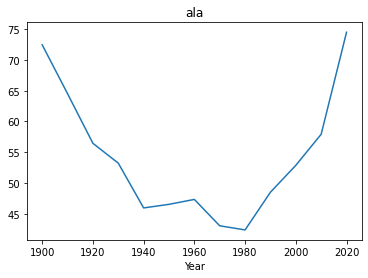

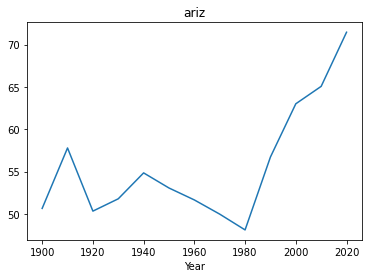

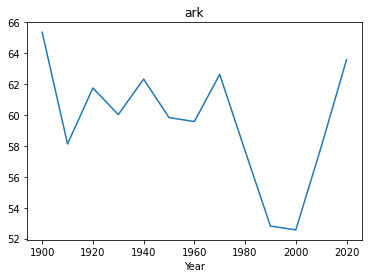

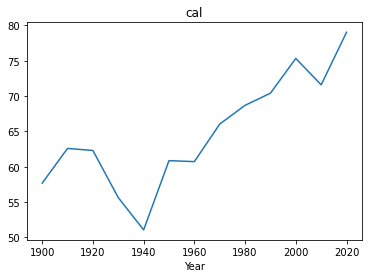

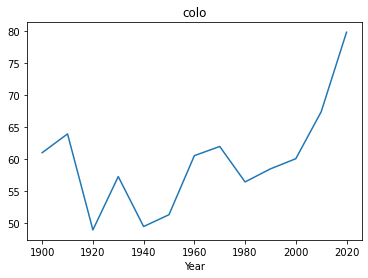

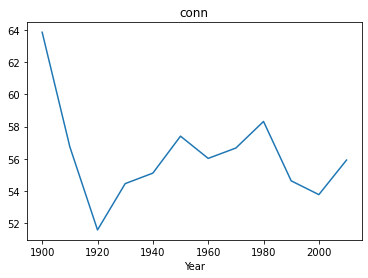

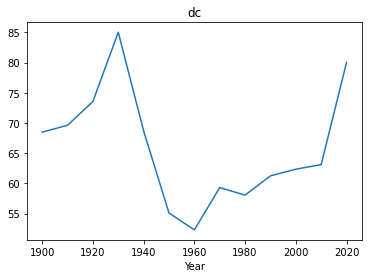

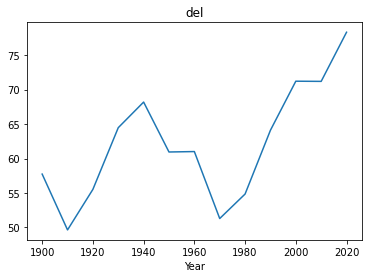

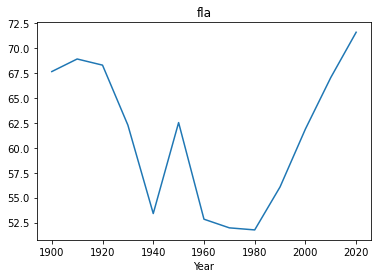

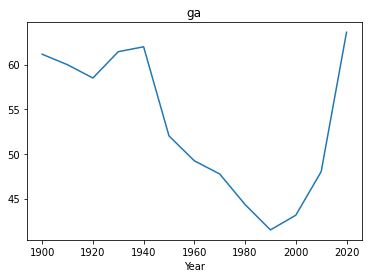

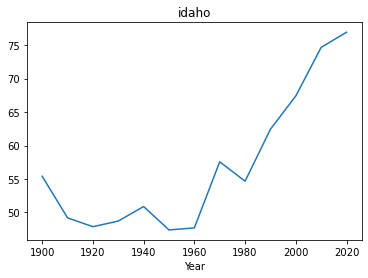

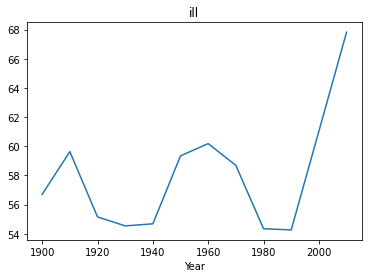

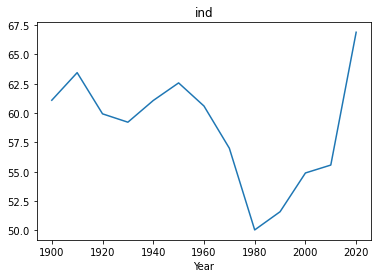

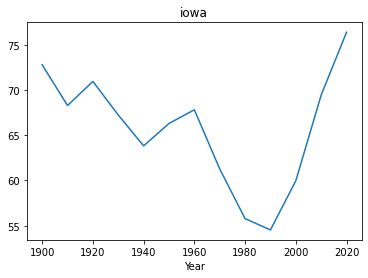

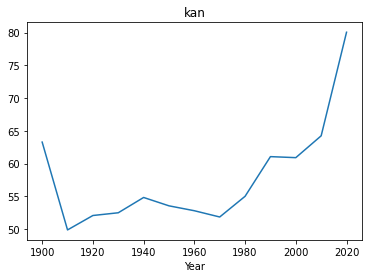

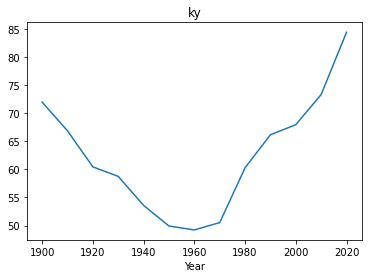

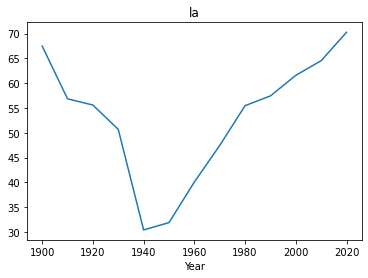

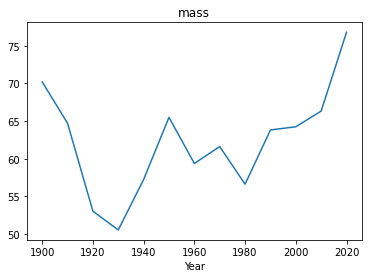

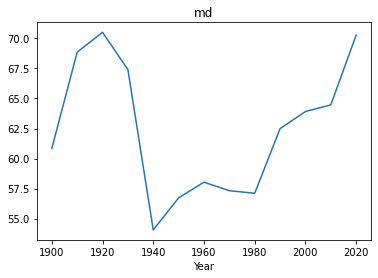

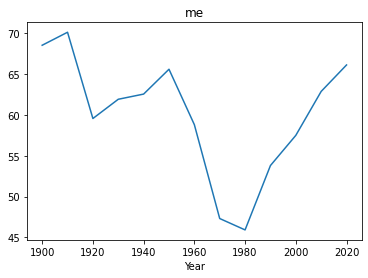

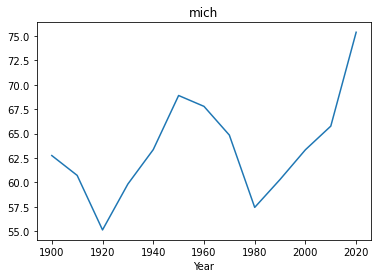

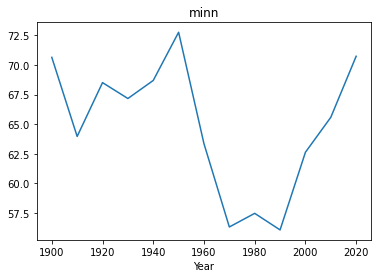

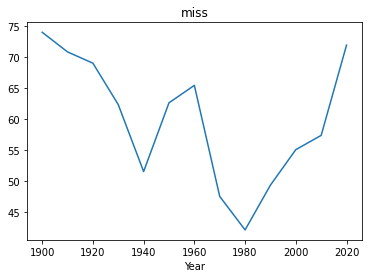

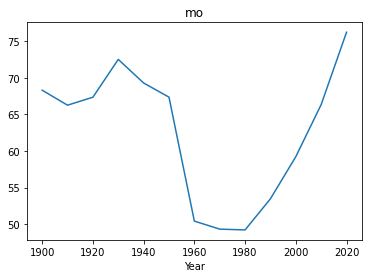

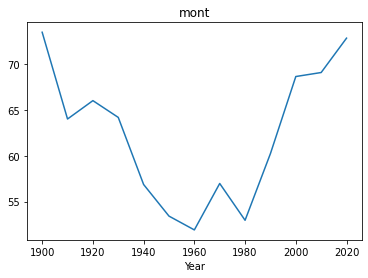

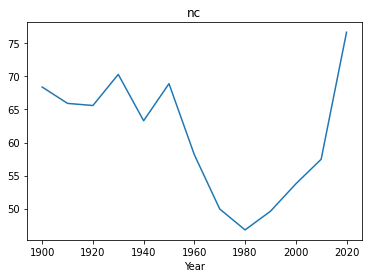

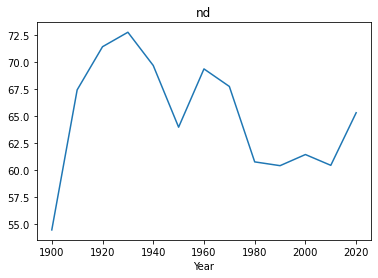

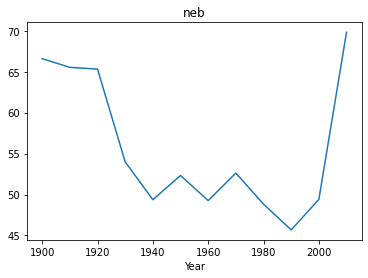

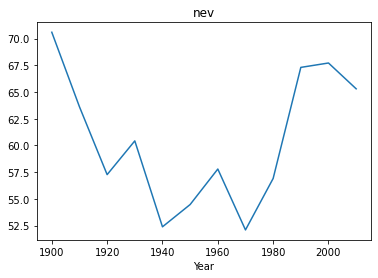

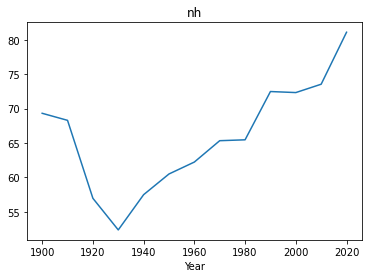

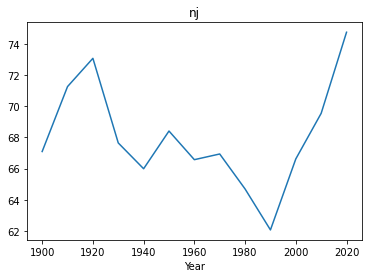

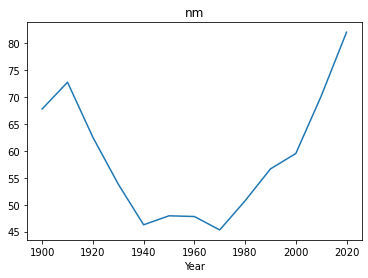

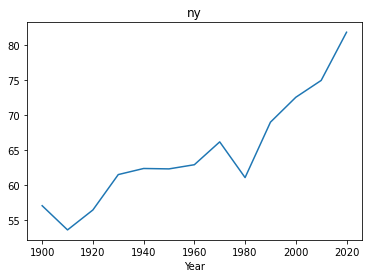

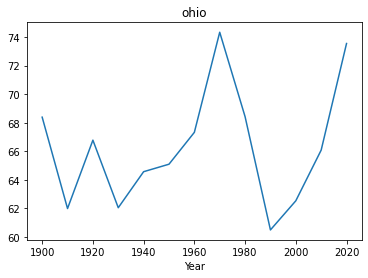

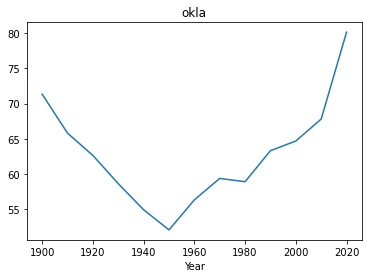

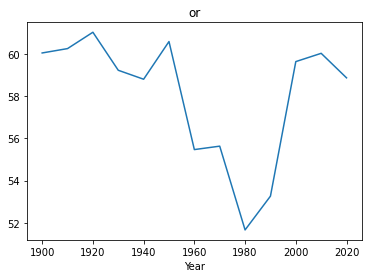

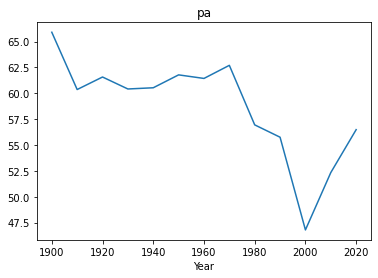

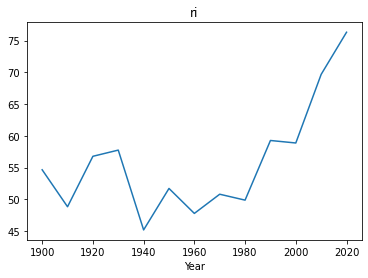

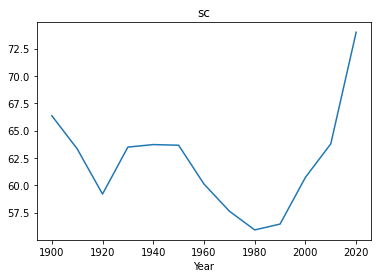

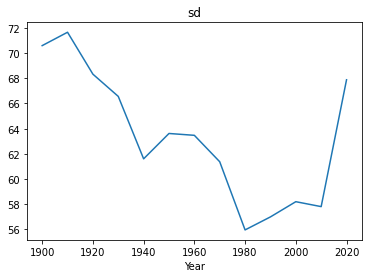

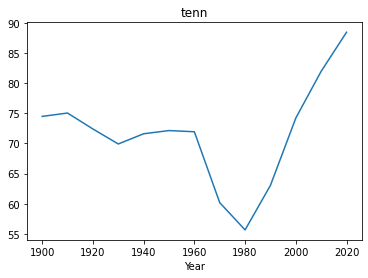

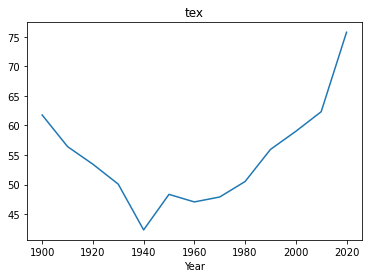

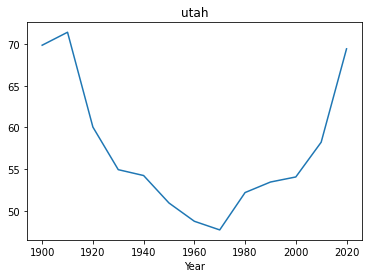

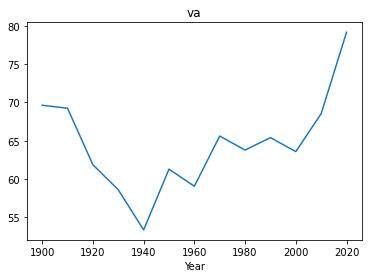

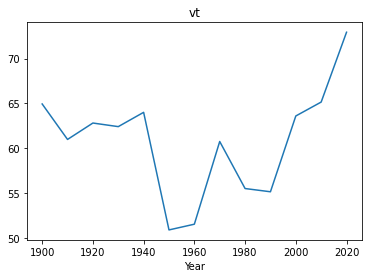

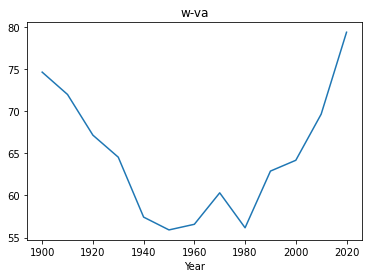

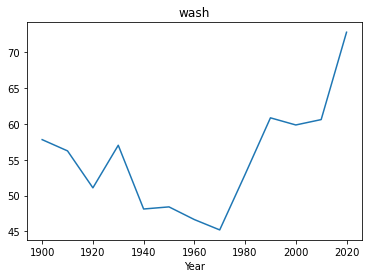

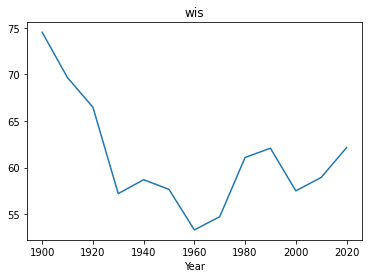

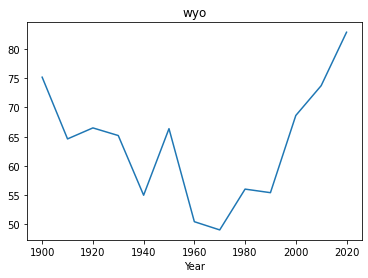

In [83]:
for state, d in r.groupby("State"):
    plt.title(state)
    d.set_index("Year").sort_values("Year", ascending=True).Percent.plot()
    plt.show()

In [84]:
states_sorted = sorted(states_code_keep)

In [85]:
# for state, dd in zip(states_sorted, results):
#     plt.title(state)
#     for year, names in dd.items(): 
#         sns.histplot(list(names.values()), label="Year")
#     plt.show()

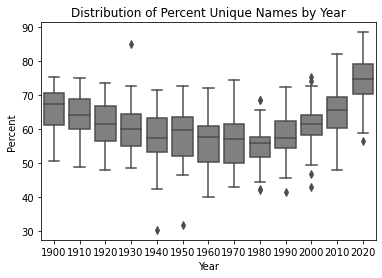

In [86]:
plt.figure(figsize=(6,4))
plt.title("Distribution of Percent Unique Names by Year")
sns.boxplot(x="Year", y="Percent", data=r, color="gray")
plt.savefig("images/unique-names-by-year.pdf")

Top 10 names for each state and year

In [87]:
for state, dd in zip(states_sorted, results):
    for year, names in dd.items():
        rx = pd.DataFrame({"Name":names.keys(), "Count":names.values()}).sort_values("Count", ascending=False)
        print("STATE", state, year)
        print(rx.iloc[:10])

STATE ala 1920
                 Name  Count
3     harwell g davis   1877
4         lamar field    604
37          j q smith    551
139        w l martin    454
151        p w turner    145
36        w w sanders    122
112         r e smith    116
152  emmett s thigpen    110
26      pinkney scott    109
405        e w godbey    106
STATE ala 2010
                    Name  Count
17             troy king   1132
94        luther strange    499
34    sharon e ficquette    228
99     bryan a stevenson     68
1679    marc james ayers     62
555      yvonne ah saxon     59
43       joseph h driver     56
142        john m porter     52
511       kevin c newsom     48
312   randall s susskind     48
STATE ala 2000
                    Name  Count
10            bill pryor   1544
4151     william h pryor    773
13         jeff sessions    762
5213           troy king    370
294   j coleman campbell    207
489        james h evans    156
147        jack w willis    134
267      yvonne ah saxon    

STATE conn 1990
                   Name  Count
5        jay b stephens   1076
2         john r fisher    731
1    charles l reischel    628
143   joseph e digenova    515
32    michael w farrell    499
207    r craig lawrence    311
31          james klein    232
206        john d bates    219
65          john payton    207
4     elizabeth trosman    189
STATE conn 1970
                  Name  Count
23        john a terry    634
22      harold h titus    408
13    richard w barton    265
50   thomas a flannery    215
12    c francis murphy    189
416    frank q nebeker    146
191      hubert b pair    143
415      david g bress    138
417     earl j silbert     89
124   charles t duncan     84
STATE conn 1920
                     Name  Count
3           conrad h syme     25
31       wilton j lambert     19
263        j j darlington     19
8           henry e davis     19
712  theodore a hostetler     19
143         john e laskey     17
141     william r ballard     17
25       w gwynn 

STATE idaho 1940
                  Name  Count
22         philip lutz    136
20      omer s jackson    127
114     james a emmert    117
104     frank hamilton     86
725    george n beamer     83
105   frank e coughlin     70
35     walter r arnold     58
690      owen s boling     46
51     james k northam     45
270  joseph p mcnamara     45
STATE idaho 1970
                      Name  Count
2        theodore l sendak   1213
44           john j dillon    421
117        robert f colker    181
5          frank e spencer     95
116          palmer k ward     89
520  harriette bailey conn     86
8               mark peden     85
160     william f thompson     84
231       robert f hassett     79
202     theodore l sendalc     78
STATE idaho 1960
                 Name  Count
12     edwin k steers    622
13      owen s boling    168
38    richard m givan     66
79      john j dillon     59
561       merl m wall     58
526   carl e van dorn     54
27    frank e spencer     54
106    keith 

STATE la 1910
                  Name  Count
0      edgar allan poe     90
17     william s bryan     54
182  isaac lobe straus     52
40           s s field     50
184    j kemp bartlett     43
105    randolph barton     38
91       frank gosnell     38
99        edgar h gans     34
119     thomas g hayes     32
145    joseph c france     31
STATE la 1920
                      Name  Count
164              s s field     79
47     alexander armstrong     72
78         edgar allan poe     68
191      isaac lobe straus     63
213              david ash     52
417        randolph barton     50
41         j kemp bartlett     48
160       philip b perlman     44
265  george weems williams     43
83        edward m hammond     39
STATE la 1950
                   Name  Count
4          hall hammond    227
164   kenneth c proctor     97
481  edward d e rollins     97
35       j edgar harvey     82
176       anselm sodaro     77
648   ambrose t hartman     53
72    thomas n biddison     52
14    

STATE miss 1990
                             Name  Count
1                     mike greely    255
37                   marc racicot    249
101            robert l deschamps     74
128                  john paulson     69
3                  patrick l paul     62
318                  mike mcgrath     52
2433  respondent joseph p mazurek     48
148                 harold hanser     45
136                  kathy seeley     42
2504      respondent marc racicot     40
STATE miss 1910
                Name  Count
31    albert j galen    164
53   william wallace     50
72          e m hall     50
32       w h poorman     48
54      john g brown     43
97       peter breen     33
96     jesse b boote     31
46         j a poore     30
77   john j mchatton     30
187        t j walsh     28
STATE miss 2000
                 Name  Count
8      dennis paxinos    160
76       john paulson    155
7     jennifer anders    151
40        brant light     98
56    tammy k plubell     86
16        jim wheel

STATE nev 1980
                       Name  Count
34            robert abrams   1523
858       louis j lefkowitz   1121
6     william e hellerstein    684
16      robert m morgenthau    680
859       ruth kessler toch    462
767   frederick a o schwarz    459
52         allen g schwartz    442
7              mario merola    415
36   shirley adelson siegel    414
973          peter h schiff    339
STATE nev 1930
                           Name  Count
807              john j bennett    578
17              albert ottinger    380
962            arthur j w hilly    373
244               hamilton ward    291
0            george p nicholson    260
1                j joseph lilly    233
981            thomas c t crain    170
49                    e c aiken    160
7577  attorneygeneral e c aiken    136
1067        corporation counsel    135
STATE nev 1960
                      Name  Count
95       louis j lefkowitz    944
256           paxton blair    566
77    peter campbell brown    512
1688 

STATE ny 1970
                      Name  Count
1616         arlen specter   2709
1615     richard a sprague   1961
2149      james d crawford   1517
650         milton m stein   1243
1629       robert w duggan    767
2075    vincent j ziccardi    675
1628        carol mary los    439
1701           john j dean    387
2065  f emmett fitzpatrick    371
1631          alan j davis    334
STATE ny 1900
                  Name  Count
31      john g johnson    235
26       john l kinsey    200
17     john gr johnson    148
100  alexander simpson    126
126        w b rodgers    104
234    thomas learning     91
82        j s ferguson     86
488  clarence burleigh     83
195         w u hensel     83
136       james alcorn     81
STATE ny 1910
                     Name  Count
22         john g johnson    257
368     alexander simpson     93
76      clarence burleigh     91
613             b f davis     87
238            w u hensel     81
75    william a challener     76
262           w b rodge

STATE sc 2020
                  Name  Count
2            salt lake   1100
13        sean d reyes    438
145      martha pierce     62
144    john m peterson     62
146  guardian ad litem     62
173          st george     36
497   carol lc verdoia     28
159     kris c leonard     26
18       ryan d tenney     25
82     jeanne b inouye     25
STATE sd 1920
                       Name  Count
8             leon m bazile    281
6           john r saunders    259
7                  j d hank    250
22   second attorneygeneral    126
16          john b saunders     61
117          lewis h machen     58
77           james g martin     32
113             e r f wells     31
5                   w s cox     28
228       samuel a anderson     28
STATE sd 1980
                  Name  Count
128   marshall coleman    252
27    gerald l baliles    163
13     andrew p miller    116
653     anthony f troy     73
226   jerry p slonaker     44
58      lewis s minter     40
273       james e kulp     39
261

STATE wash 2000
                     Name  Count
140        renee goldfarb   1497
286      richard a devine   1360
92           james e ryan   1331
218     norbert j goetten   1052
117     robert j biderman    675
157   michael j pelletier    551
106       g joseph weller    541
79      william l browers    531
5641     joel d bertocchi    496
100            rita a fry    491
STATE wash 2010
                    Name  Count
30          lisa madigan    652
18   michael j pelletier    618
34    james e fitzgerald    583
2       richard a devine    508
221    robert j biderman    338
31      michael a scodro    305
95      lawrence m bauer    304
94     norbert j goetten    282
860      patricia unsinn    243
131      thomas a lilien    229
STATE wash 1900
                     Name  Count
190      charles m walker    239
216           john a rose    211
307            h j hamlin    151
312  edgar bronson tolman    151
218            w w gurley    150
431      charles s deneen    135
499   

# Ambiguous and Misspelled Names

Uses `results` from previous section

In [114]:
# uses `results` from previous section

# results2 = []
# for state, dd in zip(states_sorted, results):
#     for year, namelist in dd.items():
#         if year not in (1900, 2010): continue
#         c = 0
#         total = 0
#         for node in namelist.keys():
#             total += 1
#             names = node.split(" ")
#             if len(names)==2:
#                 if len(names[0])==1:
#                     c += 1
#             if len(names)>=3:
#                 if len(names[0])==1 and len(names[1])==1:
#                     c += 1
#         results2.append([state, year, c, total, c/total*100.0])
# r = pd.DataFrame(results2, columns=("State", "Year", "Initials", "Total", "Percent"))

In [135]:
@parloop(flatten=True, jobs=10)
def processInitials(state):
    results = []
    st = states_code[state]
    name = states_name[st]
    g = G_names[state] # loadYearlyNames(state)
    for year in (1900, 2010):
        c = 0
        total = 0
        for node in g[year]:
            total += 1
            names = node.split(" ")
            if len(names)==2:
                if len(names[0])==1:
                    c += 1
            if len(names)>=3:
                if len(names[0])==1 and len(names[1])==1:
                    c += 1
        results.append([name, year, c, total, c/total*100.0])
    return results

results = processInitials(states_code_keep)
r = pd.DataFrame(results, columns=("State", "Year", "Initials", "Total", "Percent"))

In [136]:
r

,State,Year,Initials,Total,Percent
0,Alabama,1900,1277,2506,50.957702
1,Alabama,2010,4,7993,0.050044
2,Arizona,1900,171,310,55.161290
3,Arizona,2010,3,5289,0.056721
4,California,1900,959,2175,44.091954
...,...,...,...,...,...
93,Illinois,2010,2,2562,0.078064
94,North Carolina,1900,129,306,42.156863
95,North Carolina,2010,4,2527,0.158290
96,New Mexico,1900,423,1489,28.408328


In [137]:
d = r.pivot("State", "Year", "Percent").sort_values(2010, ascending=False)
d[:10]

Year,1900,2010
State,,
Nebraska,3.718750,0.658314
North Dakota,3.243744,0.611621
Oregon,50.636303,0.518135
New Mexico,28.408328,0.504587
New York,35.095036,0.501190
Colorado,3.438596,0.481815
Tennessee,52.941176,0.476190
Indiana,58.619798,0.474918
Wisconsin,56.409186,0.474479


In [138]:
d = r.pivot("State", "Year", "Percent").sort_values(1900, ascending=False)
d[:10]

Year,1900,2010
State,,
Kentucky,80.965279,0.066181
Idaho,64.734863,0.054840
Rhode Island,63.787624,0.160131
Pennsylvania,63.114301,0.125716
Florida,62.623907,0.410344
Missouri,60.594796,0.140647
West Virginia,59.766764,0.336549
Indiana,58.619798,0.474918
Texas,57.766722,0.144844


In [139]:
fn="perc-initials"
with open(f"document/tables/{fn}.tex", "w") as f:
    f.write(d[:10].to_latex(caption=f"Percent Nodes Using Initials - Top 10 in 1900", label=fn, position="H", float_format="%.1f"))

FileNotFoundError: [Errno 2] No such file or directory: 'document/tables/perc-initials.tex'

In [140]:
@parloop(flatten=True)
def processInitialsAmb(state):
    results = []
    st = states_code[state]
    stname = states_name[st]
    g = G_names[state] # loadYearlyNames(state)
    for year in years:
        last = {}
        c = 0
        total = 0
        for name in g[year]:
            names = name.split(" ")
            if len(names) < 2: continue
            if names[-1] in ("I", "II", "III", "IV", "Jr", "Sr"):
                lname = names[-2]
            else:
                lname = names[-1]
            initials = [n[0] for n in names if len(n)>0]
            initials_name = " ".join(initials) + " " + lname
#             print(name, "=>", initials_name)
            if initials_name in last:
                last[initials_name].add(name)
            else:
                last[initials_name] = {name,}
            total += 1
#                 print(node)
        last = {k:v for k,v in last.items() if k in g[year] and len(v)>1}
        results.append([stname, year, len(last), total])
    return results

results = processInitialsAmb(states_code_keep)

r = pd.DataFrame(results, columns=("State", "Year", "Initials", "Total"))

In [141]:
r["Percent"] = (r["Initials"] / r["Total"] * 100)
d = r.pivot("State", "Year", "Percent")[[1900, 2010]].sort_values(2010, ascending=False)
d[:10]

Year,1900,2010
State,,
Alabama,0.039904,0.0
Nebraska,0.000000,0.0
New Hampshire,0.041524,0.0
New Jersey,0.000000,0.0
New Mexico,0.000000,0.0
New York,0.024060,0.0
North Carolina,0.000000,0.0
North Dakota,0.000000,0.0
Ohio,0.000000,0.0


In [80]:
fn="perc-initials-amb"
with open(f"document/tables/{fn}.tex", "w") as f:
    f.write(d[:10].to_latex(caption=f"Percent Nodes Using Ambiguous Initials - Top 10 in 2010", label=fn, position="H", float_format='%.2f'))

In [142]:
d = r.sort_values("Percent", ascending=False).set_index("State")
d[:10]

,Year,Initials,Total,Percent
State,,,,
Kansas,1930,5,4304,0.116171
Michigan,1940,2,2047,0.097704
Idaho,1900,7,7713,0.090756
Iowa,1940,4,4469,0.089505
South Carolina,1920,1,1141,0.087642
Mississippi,1940,1,1254,0.079745
New Mexico,1930,2,2619,0.076365
Connecticut,1900,1,1539,0.064977
Rhode Island,1910,4,6835,0.058522


In [143]:
fn="perc-initials-worst"
with open(f"document/tables/{fn}.tex", "w") as f:
    f.write(d[:10].to_latex(caption=f"Ambiguous Initials - Top 10", label=fn, position="H", float_format='%.1f'))

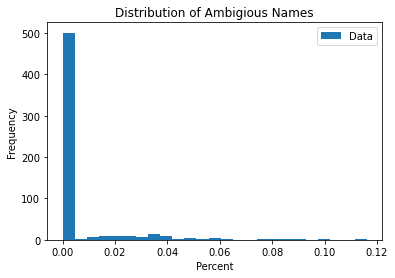

In [144]:
plotDistribution(r.Percent, title="Distribution of Ambigious Names", file="images/dist-initials.pdf", bins=25, xlabel="Percent")

In [145]:
# plt.title("Distribution of Ambigious Names")
# plt.hist(d.Percent)
# plt.xlabel("Percent")
# plt.savefig("images/dist-initials.pdf")

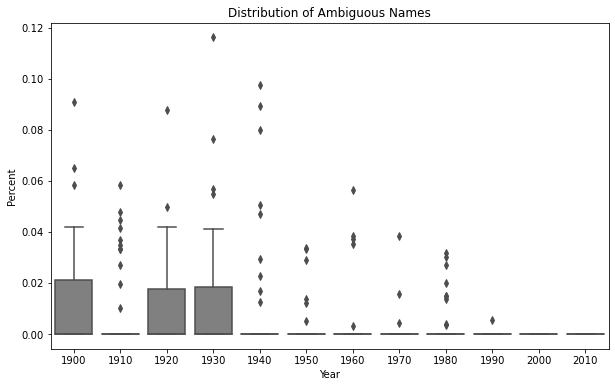

In [146]:
plt.figure(figsize=(10,6))
sns.boxplot(y="Percent", x="Year", color="gray", data=r)
plt.title("Distribution of Ambiguous Names")
plt.savefig("images/perc-initials-per-year")

In [147]:
fn="perc-initials-per-year"
with open(f"document/tables/{fn}.tex", "w") as f:
    f.write(d.to_latex(caption=f"Median Percent Initials Per Year", label=fn, position="H", float_format='%.2f'))

## Nicknames

In [148]:
from nicknames import NameDenormalizer
nickname = NameDenormalizer()

def nameVariations(x):
    results = []
    hn = HumanName(x)
    sub = nickname.get(hn.first)
#     print(sub)
    if sub == hn.first:
        return
    for s in sub:
        hn.first = s.capitalize()
        if hn.full_name == x: continue
        yield hn.full_name

print("test", list(nameVariations("Bill Bell")))            

test ['Willis Bell', 'Fred Bell', 'Billy Bell', 'Will Bell', 'Wilbur Bell', 'Willie Bell', 'Bela Bell', 'Robert Bell', 'Willy Bell', 'William Bell', 'Bell Bell']


In [149]:
def processNicknames(state):
    nk = {}
    g = G_names[state] # loadYearlyNames(state)
    count = 0
    for year in years:
        for node in g[year]:
            count += 1
            for n in nameVariations(node):
                if n == node: continue
                if n in g[year]:
#                     print(node, "=>", n)
                    if len(node) > len(n):
                        nk[year, n] = node
                    else:
                        nk[year, node] = n
    return state, count, nk

names_lookup = {}
names_total = {}
for state, num, v in runParallel(processNicknames, states_code_keep):
    names_lookup[state] = v
    names_total[state] = num

# with Pool(15) as p:
#     results = p.map(processNicknames, states_code_keep)
# names_lookup = {state:v for state, num, v in results}
# names_total = {state:num for state, num, v in results}

In [150]:
table = []
for state, v in names_lookup.items():
    st = states_code[state]
    stname = states_name[st]
    table.append([stname, len(v), names_total[state]])
r = pd.DataFrame(table, columns=("State", "Nicknames", "Total"))
r["Percent"] = r["Nicknames"] / r["Total"] * 100
r.sort_values("Percent", ascending=False)[:10]

,State,Nicknames,Total,Percent
25,Nevada,29,290393,0.009986
39,Virginia,3,42862,0.006999
3,Colorado,3,45312,0.006621
12,Kansas,8,137371,0.005824
29,Ohio,1,17295,0.005782
15,Massachusetts,1,18987,0.005267
9,Idaho,3,63118,0.004753
48,New Mexico,2,43671,0.004580
16,Maryland,3,67354,0.004454
10,Indiana,2,45451,0.004400


In [151]:
d = r.sort_values("Nicknames", ascending=False).set_index("State")
fn="nicknames-state-top10"
with open(f"document/tables/{fn}.tex", "w") as f:
    f.write(d[:10].to_latex(caption=f"Nicknames Used per State", label=fn, position="H", float_format='%.1f'))

## Misspelled names

In [152]:
# random.sample(states_code_keep, 5)
random_states = ['ark', 'nc', 'minn', 'nev', 'wis']

In [153]:
import fuzzy
import random
dmeta = fuzzy.DMetaphone()

def testStateNames(state):
    results = []
    st = states_code[state]
    stname = states_name[st]
    g = G_names[state] # loadYearlyNames(state)
    for year in years:
        total = 0
        c = 0
        table = {}
        for node in g[year]:
            total += 1
            # ie, Emmet O’Neal fails as non-ascii due to apostrophe
#             if not node[0].isalpha(): continue
            name = node.encode('ascii', 'ignore')
            # print(name, str(node))
            h = [dmeta(n)[0] for n in name.split(b" ")]
            hh = b" ".join([n for n in h if n])
            if hh in table:
                table[hh].add(node)
                c += 1
            else:
                table[hh] = {node}

        for dup, v in table.items():
            if len(v)<=1: continue
            names = list(table[dup])
            for n in names[1:]:
                names_lookup[state][year, n] = names[0]

#         sumdup = 0
#         sumtot = 0
#         for k,v in table.items():
#             sumtot += len(v)
#             if len(v)>1:
#                 sumdup += len(v)-1
                    
#         if state=="ky" and year==1940: 
#             print("sum", sumdup, sumtot, c, total)
        
        results.append([stname, year, c, total, c/total*100])
        
        # show random sample for review
        if year in (1900, 1950, 2010) and state in random_states:
#             continue # debug
            print("Duplicated", state, year)
            dups = [k for k, v in table.items() if len(v)>1]
            if len(dups)<=5:
                dups = table.keys()
            for key in random.sample(dups, 5):
                if len(table[key]) > 1:
                    print(key, table[key])
                    
    return results

results = runParallel(testStateNames, states_code_keep, flatten=True)
    
# with Pool(10) as p:
#     results = p.map(testStateNames, states_code_keep)
# results = np.concatenate(results)
    
r = pd.DataFrame(results, columns=("State", "Year", "Duplicates", "Total", "Percent"))

In [154]:
r[r.State=="Kentucky"]

,State,Year,Duplicates,Total,Percent
156,Kentucky,1900,363,4061,8.938685
157,Kentucky,1910,322,3690,8.726287
158,Kentucky,1920,242,3156,7.667934
159,Kentucky,1930,240,3323,7.222389
160,Kentucky,1940,402,4573,8.790728
161,Kentucky,1950,133,3446,3.859547
162,Kentucky,1960,196,4234,4.629192
163,Kentucky,1970,168,4361,3.852327
164,Kentucky,1980,253,7756,3.261991
165,Kentucky,1990,124,6924,1.790872


mean,var,skew,kurtosis (array(5.7237486), array(17.58349301)) parm (0.6832813977110817, 0.2875633291139809, 4.30441329404969)
mean 5.723748600710885
fit KstestResult(statistic=0.0572771382471996, pvalue=0.27894459082792367)


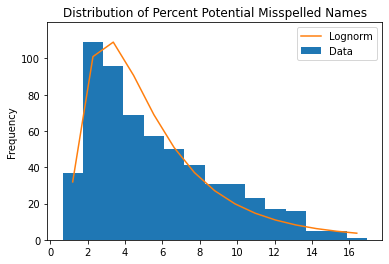

In [155]:
plotDistribution(r.Percent, "lognorm", title="Distribution of Percent Potential Misspelled Names", file="images/perc-dupl-names.pdf", bins=15)

In [156]:
# plt.title("Distribution of Percent Misspelled Names")
# r.Percent.hist()
# plt.savefig("images/perc-dupl-names.pdf")
r.Percent.mean()

5.636846592674852

In [157]:
ev = 6.5
est_err_rate = 21 / 735
est_err_rate, ev, est_err_rate * ev

(0.02857142857142857, 6.5, 0.18571428571428572)

In [158]:
r.sort_values("Percent", ascending=False)

,State,Year,Duplicates,Total,Percent
86,Florida,1920,1363,8046,16.940094
1,Alabama,1910,473,3050,15.508197
300,Nevada,1900,5074,33299,15.237695
108,Idaho,1900,1163,7713,15.078439
87,Florida,1930,1107,7359,15.042805
...,...,...,...,...,...
259,Missouri,1970,5,567,0.881834
51,Connecticut,1930,2,227,0.881057
575,North Carolina,2010,21,2527,0.831025
52,Connecticut,1940,5,642,0.778816


In [159]:
sorted(list(G_names["ky"][1940]))[:20]

['a a albert',
 'a a cohen',
 'a a davis',
 'a a gaucher',
 'a a gauthier',
 'a a gcmcher',
 'a a gelinas',
 'a a giddon',
 'a a ginzberg',
 'a a gleason',
 'a a karp',
 'a a philbin',
 'a a sutherland',
 'a a tepper',
 'a a thomson',
 'a a tucker',
 'a andrade',
 'a auger',
 'a auger s son',
 'a b bagley']

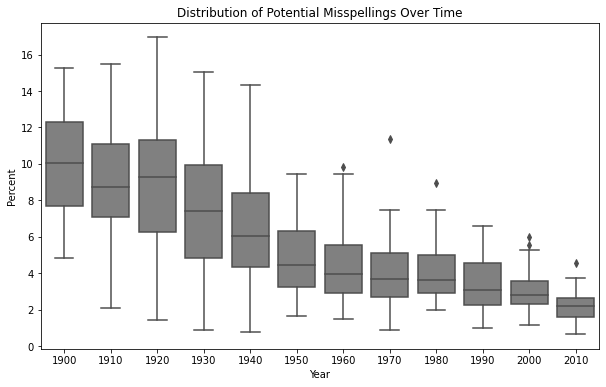

In [160]:
plt.figure(figsize=(10,6))
plt.title("Distribution of Potential Misspellings Over Time")
sns.boxplot(y="Percent", x="Year", data=r, color="gray")
plt.savefig("images/dist-perc-duplt.pdf")

In [161]:
0.028 * 0.088

0.002464

In [162]:
pickle.dump(names_lookup, open("out/names_lookup.pkl", "wb"))

# Compare all models for accuracy

Accuracy is the percent of texts where all names were correctly identified.

In [163]:
import random
@parloop(flatten=True)
def generateRandomCases(state, count=10):
    'Randomly choose cases.'
    total = 0
    data = []
    for j in loopCases(state):
        dt = j['decision_date']
        if getDecade(dt)<1900: continue   
        a = j['casebody']['data']['attorneys']
        if len(a)==0: continue
        text = random.sample(a, 1)[0]
        data.append(text)
    return random.sample(data, count)

if not os.path.exists("out/compare-test.txt"):
    random_cases = generateRandomCases(states_code_keep)

    with open("out/compare-test.txt", "w") as f:
        for text in random_cases:
            a = extractNamesState(text)
            ax = ",".join(a)
            f.write(f"TEXT:{text}\nNAMES:{ax}\n")

In [164]:
with open("out/compare-test.txt", "r") as f:
    debug = False
    results = []
    count = 0
    for line in f:
        if ":" not in line: continue
        tag,t = line.strip().split(":",1)
        if tag=="TEXT":
            count += 1
            text = t
        else:
            l = set(t.split(","))
            l_simple = set(extractNamesSimple(text, debug=debug))
            l_flair = set(extractNamesFlair(text, debug=debug))
            l_hcl = set(extractNamesHCL(text, debug=debug))
            l_state = set(extractNamesState(text, debug=debug))
            results.append([l==l_simple, l==l_flair, l==l_hcl, l==l_state])

In [165]:
df = pd.DataFrame(results, columns=("Simple","Flair","HCL","State"))
tot = len(df)
df.sum() / tot

Simple    0.651020
Flair     0.685714
HCL       0.730612
State     0.781633
dtype: float64

In [111]:
tot - df.sum()

Simple    171
Flair     154
HCL       132
State     107
dtype: int64

In [169]:
stats_agg = {}
def calculateStats(l_true, l_test, name):
    if name not in stats_agg:
        stats_agg[name] = {'fp':0,'tp':0,'fn':0}
    fp = len(l_test - l_true)
    tp = len(l_true.intersection(l_test))
    fn = len(l_true - l_test)
    stats_agg[name]['fp'] += fp
    stats_agg[name]['tp'] += tp
    stats_agg[name]['fn'] += fn
#     precision = tp / (tp+fp)
#     recall= tp / (tp+fn)
#     return precision, recall

with open("out/compare-test.txt", "r") as f:
    debug = False
    results = []
    count = 0
    for line in f:
        if ":" not in line: continue
        tag,t = line.strip().split(":",1)
        if tag=="TEXT":
            count += 1
            text = t
        else:
            l = set(t.split(","))
            calculateStats(l, set(extractNamesSimple(text, debug=debug)), "simple")
            calculateStats(l, set(extractNamesFlair(text, debug=debug)), "flair")
            calculateStats(l, set(extractNamesHCL(text, debug=debug)), "hcl")
            calculateStats(l, set(extractNamesState(text, debug=debug)), "state")
            
for name, s in stats_agg.items():
    print(name, s)
    precision = s['tp'] / (s['tp'] + s['fp'])
    recall= s['tp'] / (s['tp'] + s['fn'])
    print(name, "precison", precision, "recall", recall)

simple {'fp': 90, 'tp': 620, 'fn': 161}
simple precison 0.8732394366197183 recall 0.793854033290653
flair {'fp': 81, 'tp': 622, 'fn': 159}
flair precison 0.8847795163584637 recall 0.7964148527528809
hcl {'fp': 64, 'tp': 661, 'fn': 120}
hcl precison 0.9117241379310345 recall 0.8463508322663252
state {'fp': 49, 'tp': 692, 'fn': 89}
state precison 0.9338731443994602 recall 0.8860435339308579
